In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'+'xsec_crt_sys/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.18/04


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_crosscheck.ipynb

In [3]:
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kFALSE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_mar18.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	1012051
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.26811760704e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.0060278320856
Dirt:		0.0611423668132


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4_noflux.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	1013969
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')

energy_cut = ' && MCle_Energy>0.15'

numu_signal = numu_signal+energy_cut
numu_true = numu_true+energy_cut
numu_nomu = numu_nomu+energy_cut
numu_lowpur = numu_lowpur+energy_cut
numu_nc = numu_nc+energy_cut
numu_ov = numu_ov+energy_cut
numu_other = numu_other+energy_cut
    
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# define channels definitions

In [11]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [12]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [13]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [14]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [15]:
def plot_eff_all_w(variable,xstart,xend,xbin,xaxis_name, name,side):
    title = 'efficiency'
    weight_name = 'EventWeight*TunedCentralValue_Genie'
    ROOT.gStyle.SetOptStat(0)
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.05)
    c1.SetBottomMargin(0.14)
    
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);

    nenner_cut = 'numu_true'
    precut = 'fidVol && muon && numu_signal'
    quality_cut = ' && TrackLength>8'
    crt_cut = ' && crt_tom_cut'
    trackscore_cut = ' && TrackScore>0.8'
    tracklength_cut = ' && TrackLength>20'
    trackPID_cut = ' && TrackPID_chiproton>78'
    nuscore_cut = ' && NuScore>0.1'
    h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
    h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
    #h_init_eff_energy = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy,zahler_cut)
    #h_init_eff_energy_1 = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy_1,nenner_cut)
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    '''eff_pre =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
    eff_pre.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
    eff_pre.SetConfidenceLevel(0.68)'''
    eff_pre = h_init_eff_energy.Clone()
    eff_pre.Divide(h_init_eff_energy_1)
    
    precut = precut + quality_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_qc = h_init_eff_energy.Clone()
    eff_qc.Divide(h_init_eff_energy_1)
    
    precut = precut + crt_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_crt = h_init_eff_energy.Clone()
    eff_crt.Divide(h_init_eff_energy_1)
    
    precut = precut + trackscore_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_trkscore = h_init_eff_energy.Clone()
    eff_trkscore.Divide(h_init_eff_energy_1)
    
    precut = precut + tracklength_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_trklength = h_init_eff_energy.Clone()
    eff_trklength.Divide(h_init_eff_energy_1)
    
    precut = precut + trackPID_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_trkPID = h_init_eff_energy.Clone()
    eff_trkPID.Divide(h_init_eff_energy_1)
    
    precut = precut + nuscore_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_nuscore = h_init_eff_energy.Clone()
    eff_nuscore.Divide(h_init_eff_energy_1)
    
    if side == 'left':
        legend = ROOT.TLegend(0.3,0.15,0.85,0.3) # LEGEND LEFT
    else:
        legend = ROOT.TLegend(0.6,0.30,0.9,0.9)
    legend.SetNColumns(4)
    legend.AddEntry(eff_pre,'SliceID',"f")
    legend.AddEntry(eff_qc,'Quality cut',"f")
    legend.AddEntry(eff_crt,'CRT cut',"f")
    legend.AddEntry(eff_trkscore,'Track score cut',"f")
    legend.AddEntry(eff_trklength,'Track length cut',"f")
    legend.AddEntry(eff_trkPID,'Track PID cut',"f")
    legend.AddEntry(eff_nuscore,'Topological score cut',"f")
    
    eff_pre.SetMinimum(0)
    eff_pre.SetMaximum(1)
    eff_pre.SetLineWidth(1)
    eff_pre.GetXaxis().SetTitle(xaxis_name)
    eff_pre.GetYaxis().SetTitle("Signal efficiency")
    eff_pre.GetYaxis().SetTitleSize(0.05)
    eff_pre.GetYaxis().SetTitleOffset(0.0)
    eff_pre.GetYaxis().SetLabelSize(0.05)
    eff_pre.GetXaxis().SetTitleSize(0.05)
    eff_pre.GetXaxis().SetLabelSize(0.05)
    eff_pre.GetXaxis().SetTitleOffset(1)
    eff_pre.SetLineColor(ROOT.kOrange)
    eff_pre.SetLineWidth(3)
    ROOT.gStyle.SetEndErrorSize(3)
    eff_pre.Draw("E1")
    legend.Draw()
    eff_pre.Draw("E1 same")
    eff_qc.SetLineColor(ROOT.kRed)
    eff_qc.SetLineWidth(3)
    eff_qc.Draw("E1 same")
    eff_crt.SetLineColor(ROOT.kBlue)
    eff_crt.SetLineWidth(3)
    eff_crt.Draw("E1 same")
    eff_trkscore.SetLineColor(ROOT.kGreen-2)
    eff_trkscore.SetLineWidth(3)
    eff_trkscore.Draw("E1 same")
    eff_trklength.SetLineColor(ROOT.kYellow+2)
    eff_trklength.SetLineWidth(3)
    eff_trklength.Draw("E1 same")
    eff_trkPID.SetLineColor(ROOT.kPink-9)
    eff_trkPID.SetLineWidth(3)
    eff_trkPID.Draw("E1 same")
    eff_nuscore.SetLineColor(ROOT.kBlack)
    eff_nuscore.SetLineWidth(3)
    eff_nuscore.Draw("E1 same")
    
    prelim.Draw()
    c1.Draw()
    c1.SaveAs(globale.outputdir_png + "h_eff_"+name+".png")
    c1.SaveAs(globale.outputdir_root + "h_eff_"+name+".root")
    c1.SaveAs(globale.outputdir_pdf + "h_eff_"+name+".pdf")
    return


In [16]:
add_name = '_wo_crt'

In [17]:
add_name = '_wo_crt'
#plot_eff_all_w('MCNu_Energy',0,2.5,20,'Truth neutrino energy [GeV]','energy_all'+add_name,'left')
#plot_eff_all_w('cos(MCNu_leptonTheta)',-1,1,20,'True cos(theta)','costheta_all'+add_name,'left')
#plot_eff_all_w('MCNu_Vx',0,250,50,'Truth neutrino vertex X [cm]','Vx_all'+add_name,'left')
#plot_eff_all_w('MCNu_Vy',-120,120,50,'Truth neutrino vertex Y [cm]','Vy_all'+add_name,'left')
#plot_eff_all_w('MCNu_Vz',0,1000,50,'Truth neutrino vertex Z [cm]','Vz_all'+add_name,'left')
#plot_eff_all_w('MCTrackMomentum',0,2.5,50,'Truth muon momentum [GeV]','mom_all'+add_name,'left')

In [18]:
def plot_eff_div(variable,xstart,xend,xbin,xaxis_name, name,side):
    title = 'efficiency'
    weight_name = 'EventWeight*TunedCentralValue_Genie'
    ROOT.gStyle.SetOptStat(0)
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.05)
    c1.SetBottomMargin(0.14)
    
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);

    nenner_cut = 'numu_true'
    precut = 'fidVol && muon && TrackLength>8 && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'

    #precut = 'fidVol && muon && numu_signal'
    quality_cut = ' && TrackLength>8'
    top_vet = ' && nr_crthit_top==0'
    vertex_cut = ' && crthit_vertex_zcut==0'
    veto_cont = ' && (track_end_uncontained==1 || nr_crthit_beam_tres==0)'
    crt_asso = ' && crt_cut'
    #nuscore_cut = ' && NuScore>0.1'
    h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
    h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
    #h_init_eff_energy = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy,zahler_cut)
    #h_init_eff_energy_1 = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy_1,nenner_cut)
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    '''eff_pre =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
    eff_pre.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
    eff_pre.SetConfidenceLevel(0.68)'''
    eff_pre = h_init_eff_energy.Clone()
    eff_pre.Divide(h_init_eff_energy_1)
    
    precut = precut + quality_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_qc = h_init_eff_energy.Clone()
    eff_qc.Divide(h_init_eff_energy_1)
    
    precut = precut + top_vet
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_top_vet = h_init_eff_energy.Clone()
    h_top_vet.Divide(h_init_eff_energy_1)
    
    precut = precut + vertex_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_vertex_cut = h_init_eff_energy.Clone()
    h_vertex_cut.Divide(h_init_eff_energy_1)
    
    precut = precut + veto_cont
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_veto_cont = h_init_eff_energy.Clone()
    h_veto_cont.Divide(h_init_eff_energy_1)
    
    precut = precut + crt_asso
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_crt_asso = h_init_eff_energy.Clone()
    h_crt_asso.Divide(h_init_eff_energy_1)
    
    '''precut = precut + crt_asso
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_nuscore = h_init_eff_energy.Clone()
    eff_nuscore.Divide(h_init_eff_energy_1)'''
    
    if side == 'left':
        legend = ROOT.TLegend(0.3,0.15,0.85,0.3) # LEGEND LEFT
    else:
        legend = ROOT.TLegend(0.6,0.30,0.9,0.9)
    legend.SetNColumns(4)
    legend.AddEntry(eff_pre,'All cuts',"f")
    legend.AddEntry(eff_qc,'Quality cut',"f")
    legend.AddEntry(h_top_vet,'CRT top veto',"f")
    legend.AddEntry(h_vertex_cut,'CRT vertex cut',"f")
    legend.AddEntry(h_veto_cont,'CRT veto contained',"f")
    legend.AddEntry(h_crt_asso,'CRT association cut',"f")
    #legend.AddEntry(eff_nuscore,'Topological score cut',"f")
    
    eff_pre.SetMinimum(0)
    eff_pre.SetMaximum(1)
    eff_pre.SetLineWidth(1)
    eff_pre.GetXaxis().SetTitle(xaxis_name)
    eff_pre.GetYaxis().SetTitle("Signal efficiency")
    eff_pre.GetYaxis().SetTitleSize(0.05)
    eff_pre.GetYaxis().SetTitleOffset(0.0)
    eff_pre.GetYaxis().SetLabelSize(0.05)
    eff_pre.GetXaxis().SetTitleSize(0.05)
    eff_pre.GetXaxis().SetLabelSize(0.05)
    eff_pre.GetXaxis().SetTitleOffset(1)
    eff_pre.SetLineColor(ROOT.kOrange)
    eff_pre.SetLineWidth(3)
    ROOT.gStyle.SetEndErrorSize(3)
    eff_pre.Draw("E1")
    legend.Draw()
    eff_pre.Draw("E1 same")
    eff_qc.SetLineColor(ROOT.kRed)
    eff_qc.SetLineWidth(3)
    eff_qc.Draw("E1 same")
    h_top_vet.SetLineColor(ROOT.kBlue)
    h_top_vet.SetLineWidth(3)
    h_top_vet.Draw("E1 same")
    h_vertex_cut.SetLineColor(ROOT.kGreen-2)
    h_vertex_cut.SetLineWidth(3)
    h_vertex_cut.Draw("E1 same")
    h_veto_cont.SetLineColor(ROOT.kYellow+2)
    h_veto_cont.SetLineWidth(3)
    h_veto_cont.Draw("E1 same")
    h_crt_asso.SetLineColor(ROOT.kBlack)
    h_crt_asso.SetLineWidth(3)
    h_crt_asso.Draw("E1 same")
    
    prelim.Draw()
    c1.Draw()
    c1.SaveAs(globale.outputdir_png + "h_eff_"+name+".png")
    c1.SaveAs(globale.outputdir_root + "h_eff_"+name+".root")
    c1.SaveAs(globale.outputdir_pdf + "h_eff_"+name+".pdf")

    return


In [19]:
add_name = '_crt_detail_all_cut'
#plot_eff_div('MCNu_Energy',0,2.5,20,'Truth neutrino energy [GeV]','energy_all'+add_name,'left')
#plot_eff_div('cos(MCNu_leptonTheta)',-1,1,20,'True cos(theta)','costheta_all'+add_name,'left')
#plot_eff_div('MCNu_Vx',0,250,50,'Truth neutrino vertex X [cm]','Vx_all'+add_name,'left')
#plot_eff_div('MCNu_Vy',-120,120,50,'Truth neutrino vertex Y [cm]','Vy_all'+add_name,'left')
#plot_eff_div('MCNu_Vz',0,1000,50,'Truth neutrino vertex Z [cm]','Vz_all'+add_name,'left')
#plot_eff_div('MCTrackMomentum',0,2.5,50,'Truth muon momentum [GeV]','mom_all'+add_name,'left')

In [20]:
def cont_border(length):
    track_end_border_x = '(TrackEnd_x_sce <(-1.55+'+str(length)+') || TrackEnd_x_sce > (254.8-'+str(length)+'))'
    track_end_border_y = '(TrackEnd_y_sce <(-115.53+'+str(length)+') || TrackEnd_y_sce > (117.47-'+str(length)+'))'
    track_end_border_z = '(TrackEnd_z_sce <(0.1+'+str(length)+') || TrackEnd_z_sce > (1039.9-'+str(length)+'))'
    track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'
    return track_end_uncontained

def plot_eff_cont(variable,xstart,xend,xbin,xaxis_name, name,side):
    title = 'efficiency'
    weight_name = 'EventWeight*TunedCentralValue_Genie'
    ROOT.gStyle.SetOptStat(0)
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.05)
    c1.SetBottomMargin(0.14)
    
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);

    nenner_cut = 'numu_true'
    precut = 'fidVol && muon && TrackLength>8 && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal && nr_crthit_top==0\
                && crthit_vertex_zcut==0  && crt_cut'

    
    #precut = 'fidVol && muon && numu_signal'
    quality_cut = ' && ('+cont_border(50)+'==1 || nr_crthit_beam_tres==0)'
    top_vet = ' && ('+cont_border(20)+'==1 || nr_crthit_beam_tres==0)'
    vertex_cut = ' && ('+cont_border(10)+'==1 || nr_crthit_beam_tres==0)'
    veto_cont = ' && ('+cont_border(5)+'==1 || nr_crthit_beam_tres==0)'
    crt_asso = ' && ('+cont_border(1)+'==1 || nr_crthit_beam_tres==0)'
    nuscore_cut = ' && ('+cont_border(0)+'==1 || nr_crthit_beam_tres==0)'
    h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
    h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
    #h_init_eff_energy = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy,zahler_cut)
    #h_init_eff_energy_1 = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy_1,nenner_cut)
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    '''eff_pre =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
    eff_pre.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
    eff_pre.SetConfidenceLevel(0.68)'''
    eff_pre = h_init_eff_energy.Clone()
    eff_pre.Divide(h_init_eff_energy_1)
    
    precut = precut + quality_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_qc = h_init_eff_energy.Clone()
    eff_qc.Divide(h_init_eff_energy_1)
    
    precut = precut + top_vet
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_top_vet = h_init_eff_energy.Clone()
    h_top_vet.Divide(h_init_eff_energy_1)
    
    precut = precut + vertex_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_vertex_cut = h_init_eff_energy.Clone()
    h_vertex_cut.Divide(h_init_eff_energy_1)
    
    precut = precut + veto_cont
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_veto_cont = h_init_eff_energy.Clone()
    h_veto_cont.Divide(h_init_eff_energy_1)
    
    precut = precut + crt_asso
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    h_crt_asso = h_init_eff_energy.Clone()
    h_crt_asso.Divide(h_init_eff_energy_1)
    
    precut = precut + nuscore_cut
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy',weight_name+'*('+precut+')')
    globale.overlay_out.Draw(variable+'>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
    eff_nuscore = h_init_eff_energy.Clone()
    eff_nuscore.Divide(h_init_eff_energy_1)
    
    if side == 'left':
        legend = ROOT.TLegend(0.3,0.15,0.85,0.3) # LEGEND LEFT
    else:
        legend = ROOT.TLegend(0.6,0.30,0.9,0.9)
    legend.SetNColumns(4)
    legend.AddEntry(eff_pre,'All cuts',"f")
    legend.AddEntry(eff_qc,'50 cm',"f")
    legend.AddEntry(h_top_vet,'20 cm',"f")
    legend.AddEntry(h_vertex_cut,'10 cm',"f")
    legend.AddEntry(h_veto_cont,'5 cm',"f")
    legend.AddEntry(h_crt_asso,'1 cm',"f")
    legend.AddEntry(eff_nuscore,'0 cm',"f")
    
    eff_pre.SetMinimum(0)
    eff_pre.SetMaximum(1)
    eff_pre.SetLineWidth(1)
    eff_pre.GetXaxis().SetTitle(xaxis_name)
    eff_pre.GetYaxis().SetTitle("Signal efficiency")
    eff_pre.GetYaxis().SetTitleSize(0.05)
    eff_pre.GetYaxis().SetTitleOffset(0.0)
    eff_pre.GetYaxis().SetLabelSize(0.05)
    eff_pre.GetXaxis().SetTitleSize(0.05)
    eff_pre.GetXaxis().SetLabelSize(0.05)
    eff_pre.GetXaxis().SetTitleOffset(1)
    eff_pre.SetLineColor(ROOT.kOrange)
    eff_pre.SetLineWidth(3)
    ROOT.gStyle.SetEndErrorSize(3)
    eff_pre.Draw("E1")
    legend.Draw()
    eff_pre.Draw("E1 same")
    eff_qc.SetLineColor(ROOT.kRed)
    eff_qc.SetLineWidth(3)
    eff_qc.Draw("E1 same")
    h_top_vet.SetLineColor(ROOT.kBlue)
    h_top_vet.SetLineWidth(3)
    h_top_vet.Draw("E1 same")
    h_vertex_cut.SetLineColor(ROOT.kGreen-2)
    h_vertex_cut.SetLineWidth(3)
    h_vertex_cut.Draw("E1 same")
    h_veto_cont.SetLineColor(ROOT.kYellow+2)
    h_veto_cont.SetLineWidth(3)
    h_veto_cont.Draw("E1 same")
    h_crt_asso.SetLineColor(ROOT.kPink-9)
    h_crt_asso.SetLineWidth(3)
    h_crt_asso.Draw("E1 same")
    eff_nuscore.SetLineColor(ROOT.kBlack)
    eff_nuscore.SetLineWidth(3)
    eff_nuscore.Draw("E1 same")
    
    prelim.Draw()
    c1.Draw()
    c1.SaveAs(globale.outputdir_png + "h_eff_"+name+".png")
    c1.SaveAs(globale.outputdir_root + "h_eff_"+name+".root")
    c1.SaveAs(globale.outputdir_pdf + "h_eff_"+name+".pdf")
    return


In [21]:
add_name = '_crt_cont_cut'
#plot_eff_cont('MCNu_Energy',0,2.5,20,'Truth neutrino energy [GeV]','energy_all'+add_name,'left')
#plot_eff_cont('cos(MCNu_leptonTheta)',-1,1,20,'True cos(theta)','costheta_all'+add_name,'left')
#plot_eff_cont('MCNu_Vx',0,250,50,'Truth neutrino vertex X [cm]','Vx_all'+add_name,'left')
#plot_eff_cont('MCNu_Vy',-120,120,50,'Truth neutrino vertex Y [cm]','Vy_all'+add_name,'left')
#plot_eff_cont('MCNu_Vz',0,1000,50,'Truth neutrino vertex Z [cm]','Vz_all'+add_name,'left')
#plot_eff_cont('MCTrackMomentum',0,2.5,50,'Truth muon momentum [GeV]','mom_all'+add_name,'left')

In [22]:
cut = 'fidVol && muon && TrackLength>8 && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
cut = cut + '&& nr_crthit_top==0 && crthit_vertex_zcut==0  && crt_cut'
name = '_no_cont_veto'
side_right = 'right'
side_left = 'left'
#NuCC_w.make_stacked_histo_weightV2(cut,'TrackMomMCS_mom','EventWeight','Reco. muon track momentum (MCS) [GeV]',0,2,20,'TrackMom'+name,side_right)


In [23]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
#cut = cut + '&& nr_crthit_top==0 && crthit_vertex_zcut==0  && crt_cut'
name = '_all_cut'
side_right = 'right'
side_left = 'left'
#NuCC_w.make_stacked_histo_weightV2(cut,'TrackMomMCS_mom','EventWeight','Reco. muon track momentum (MCS) [GeV]',0,2,20,'TrackMom'+name,side_right)


In [24]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

N_data = data_out.GetEntries(cut)
N_ext  = ext_out.GetEntries(cut)*scale_out[ext_out]
N_dirt = dirt_out.GetEntries(cut)*scale_out[dirt_out]
N_overlay = overlay_out.GetEntries(cut+'&& !numu_signal')*scale_out[overlay_out]
N_signal = overlay_out.GetEntries(cut+'&& numu_signal')*scale_out[overlay_out]
N_true = overlay_out.GetEntries('numu_true')*scale_out[overlay_out]

h_weight_func = ROOT.TH1F("h_weight_func",'h_weight_func',10000,0,1000)
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && 1','0')
dirt_pass_weight = h_weight_func.GetMean() 
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && numu_signal','0') # weights for signal definition
overlay_signal = h_weight_func.GetMean()
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && !numu_signal','0') # weights for signal definition
overlay_pass_weight = h_weight_func.GetMean()

overlay_out.Draw(weight_name+'>>h_weight_func',numu_true,'0') # weights for signal definition
overlay_true_weight = h_weight_func.GetMean()

N_dirt = N_dirt*dirt_pass_weight
N_overlay = N_overlay*overlay_pass_weight
N_signal = N_signal*overlay_signal
N_true = N_true*overlay_true_weight
eff = N_signal/N_true

sigma_tot = (N_data- (N_ext+N_dirt+N_overlay))/(eff*beam_flux*N_tot)
print 'Number of data:', N_data
print 'Number of ext:', N_ext
print 'Number of dirt:', N_dirt
print 'Number of overlay:', N_overlay
print 'Number of overlay signal:', N_signal
print 'Number of overlay true:', N_true
print 'Efficiency: ',eff
print 'Total integrated cross section:', sigma_tot

#N_signal = N_signal*scale_out[overlay_out]
sigma_tot_MC = (N_signal)/(eff*beam_flux*N_tot)
print 'Total integrated cross section for MC:', sigma_tot_MC

Number of data: 1348
Number of ext: 142.179032863
Number of dirt: 32.1859727109
Number of overlay: 199.823289107
Number of overlay signal: 972.631089505
Number of overlay true: 1748.61996689
Efficiency:  0.556227829903
Total integrated cross section: 7.56433766481e-39
Total integrated cross section for MC: 7.55516692203e-39


In [25]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

N_data_wocrt = data_out.GetEntries(cut)
N_ext_wocrt  = ext_out.GetEntries(cut)*scale_out[ext_out]
N_dirt_wocrt = dirt_out.GetEntries(cut)*scale_out[dirt_out]
N_overlay_wocrt = overlay_out.GetEntries(cut+'&& !numu_signal')*scale_out[overlay_out]
N_signal_wocrt = overlay_out.GetEntries(cut+'&& numu_signal')*scale_out[overlay_out]
N_true = overlay_out.GetEntries('numu_true')*scale_out[overlay_out]

h_weight_func = ROOT.TH1F("h_weight_func",'h_weight_func',10000,0,1000)
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && 1','0')
dirt_pass_weight = h_weight_func.GetMean() 
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && numu_signal','0') # weights for signal definition
overlay_signal = h_weight_func.GetMean()
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && !numu_signal','0') # weights for signal definition
overlay_pass_weight = h_weight_func.GetMean()

overlay_out.Draw(weight_name+'>>h_weight_func',numu_true,'0') # weights for signal definition
overlay_true_weight = h_weight_func.GetMean()

N_dirt_wocrt = N_dirt_wocrt*dirt_pass_weight
N_overlay_wocrt = N_overlay_wocrt*overlay_pass_weight
N_signal_wocrt = N_signal_wocrt*overlay_signal
N_true = N_true*overlay_true_weight
eff_wocrt = N_signal_wocrt/N_true

sigma_tot_wocrt = (N_data_wocrt- (N_ext_wocrt+N_dirt_wocrt+N_overlay_wocrt))/(eff_wocrt*beam_flux*N_tot)
print 'Number of data:', N_data_wocrt
print 'Number of ext:', N_ext_wocrt
print 'Number of dirt:', N_dirt_wocrt
print 'Number of overlay:', N_overlay_wocrt
print 'Number of overlay signal:', N_signal_wocrt
print 'Number of overlay true:', N_true
print 'Efficiency: ',eff_wocrt
print 'Total integrated cross section:', sigma_tot_wocrt

#N_signal_wocrt = N_signal_wocrt*scale_out[overlay_out]
sigma_tot_MC_wocrt = (N_signal_wocrt)/(eff_wocrt*beam_flux*N_tot)
print 'Total integrated cross section for MC:', sigma_tot_MC_wocrt

Number of data: 1720
Number of ext: 366.81996906
Number of dirt: 54.1031485264
Number of overlay: 261.385209994
Number of overlay signal: 1051.08787952
Number of overlay true: 1748.61996689
Efficiency:  0.601095663683
Total integrated cross section: 7.45887565774e-39
Total integrated cross section for MC: 7.55516692203e-39


Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [26]:
ineff = 0.1

N_bkg_sys = (N_overlay_wocrt-N_overlay)*ineff+N_overlay
N_dirt_sys = (N_dirt_wocrt-N_dirt)*ineff+N_dirt
N_sig_sys = (N_signal_wocrt-N_signal)*ineff+N_signal
eff_sys = N_sig_sys/N_true

sigma_tot_sys = (N_data- (N_ext+N_dirt_sys+N_bkg_sys))/(eff_sys*beam_flux*N_tot)
print sigma_tot_sys
print 'Difference: ',(sigma_tot_sys - sigma_tot)*100.0/sigma_tot


7.43948287975e-39
Difference:  -1.65057128056


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_time_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_time_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/pdf/h_crt_time_corr.pdf has been created


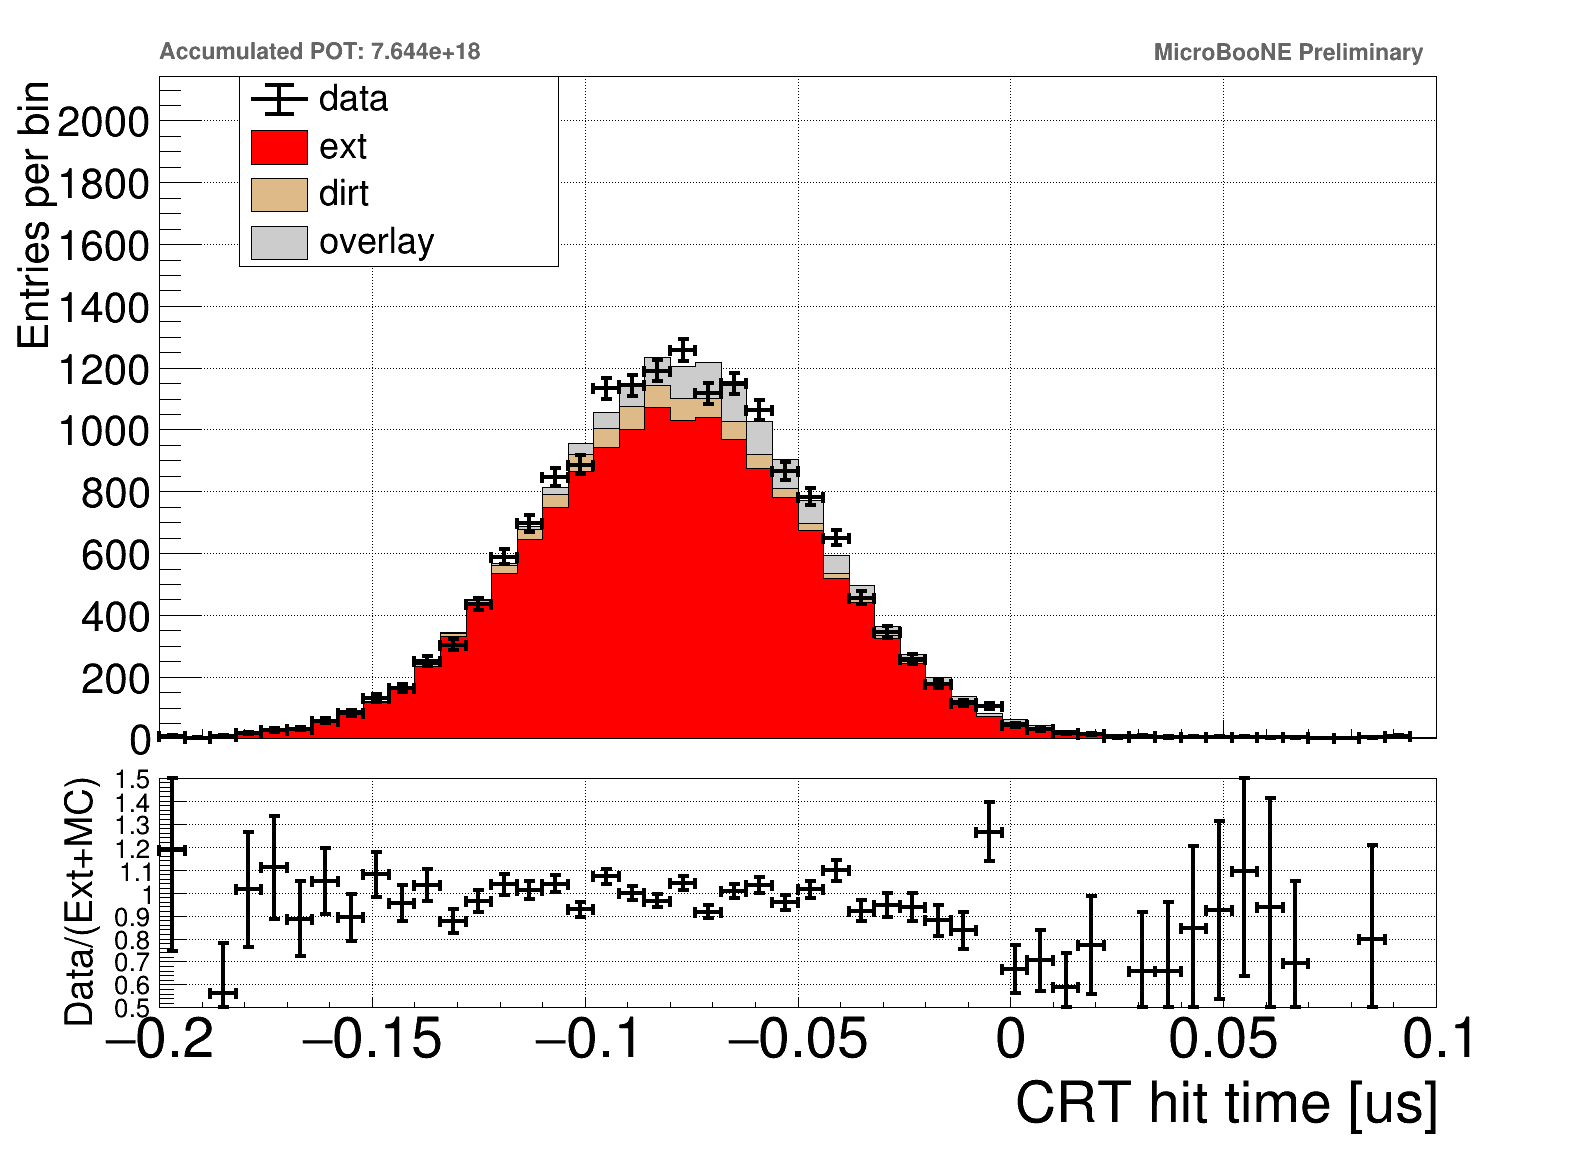

In [27]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 50
xstart = -0.2
xend = 0.1
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

cut = 'crt_adc>70'
#cut = '1'

data.Draw('crthit_ts0-TimFla>>h_data',cut)
ext.Draw('crthit_ts0-TimFla>>h_ext',cut)#-3.57+3.195-
overlay.Draw('crthit_ts0+0.4-TimFla>>h_overlay',cut,'')
dirt.Draw('crthit_ts0+0.4-TimFla>>h_dirt',cut,'')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT hit time [us]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
h_data.SetMaximum(h_ext.GetMaximum()*2)
h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_time_corr.png")
c1.SaveAs(outputdir_root + "h_crt_time_corr.root")
c1.SaveAs(outputdir_pdf + "h_crt_time_corr.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_time_uncorr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_time_uncorr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xse

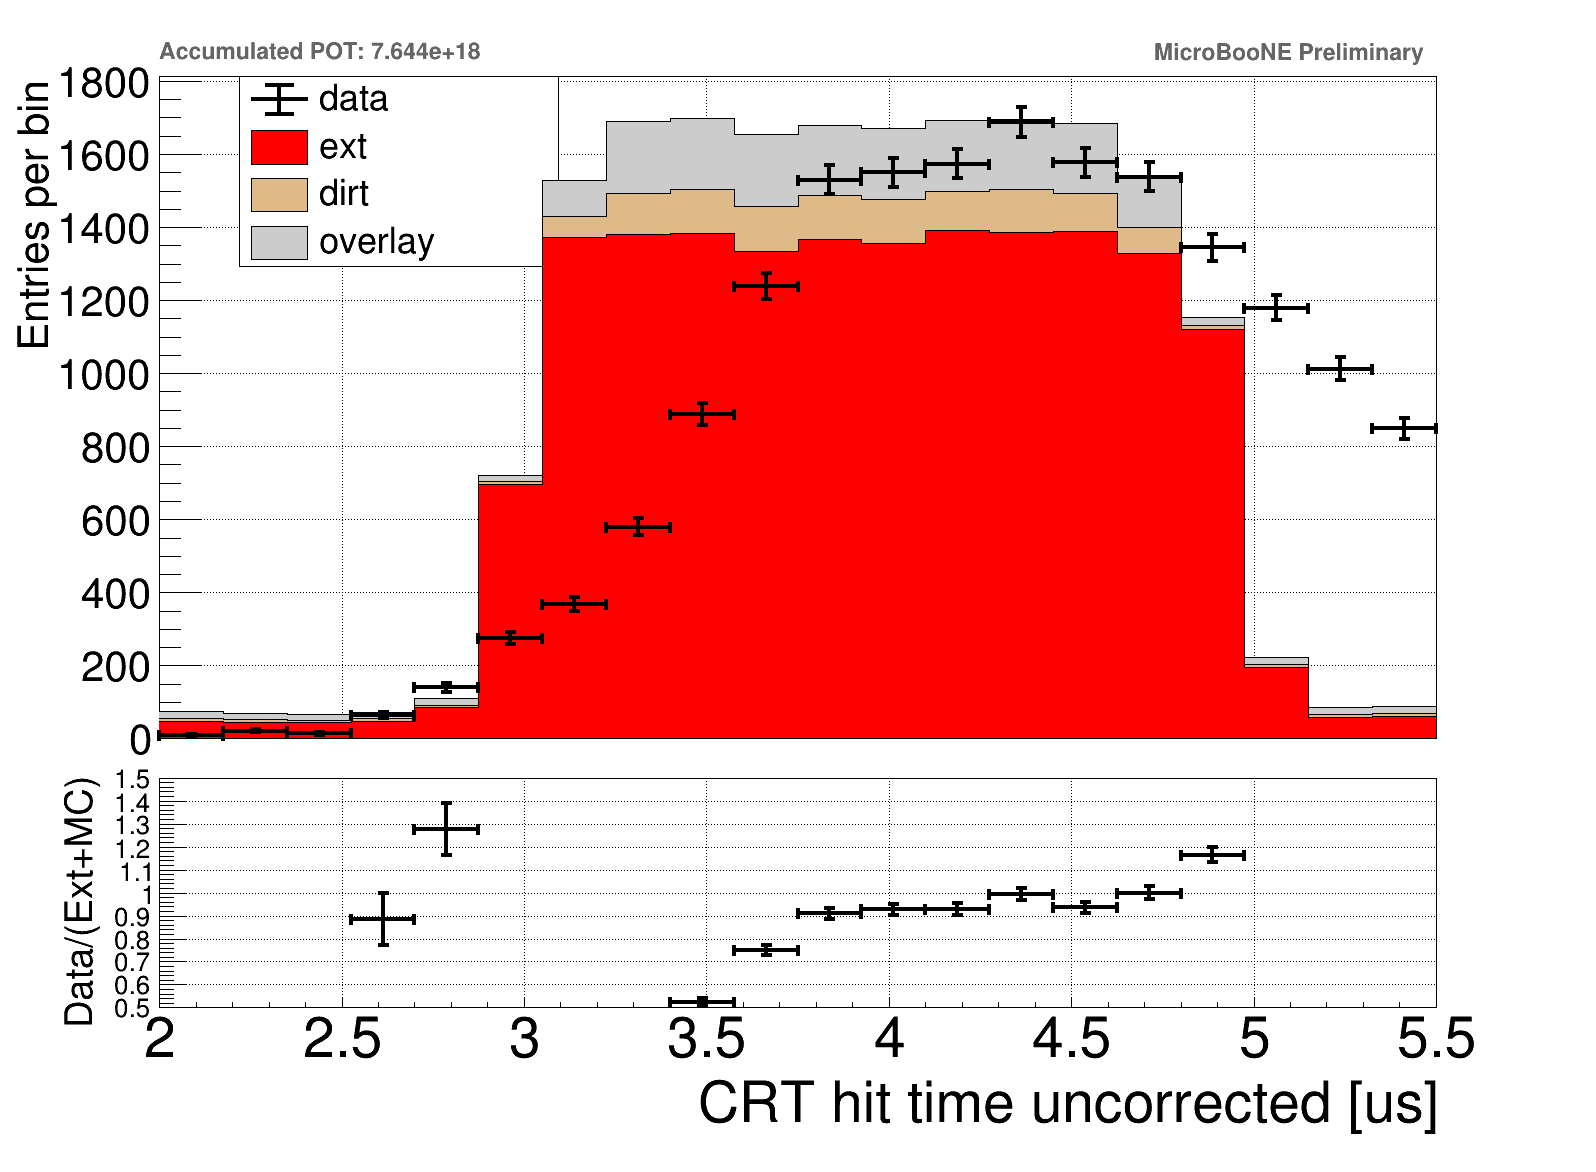

In [28]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 20
xstart = 2
xend = 5.5
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

cut = 'crt_adc>70'
#cut = '1'

data.Draw('crthit_ts0-(crt_trig_corr_med)/1000>>h_data',cut)
ext.Draw('crthit_ts0-(crt_trig_corr_med)/1000>>h_ext',cut)
overlay.Draw('crthit_ts0>>h_overlay',cut,'')
dirt.Draw('crthit_ts0>>h_dirt',cut,'')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT hit time uncorrected [us]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_time_uncorr.png")
c1.SaveAs(outputdir_root + "h_crt_time_uncorr.root")
c1.SaveAs(outputdir_pdf + "h_crt_time_uncorr.pdf")

Scale:  0.949967130269


Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_time_corr_all.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_time_corr_all.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved

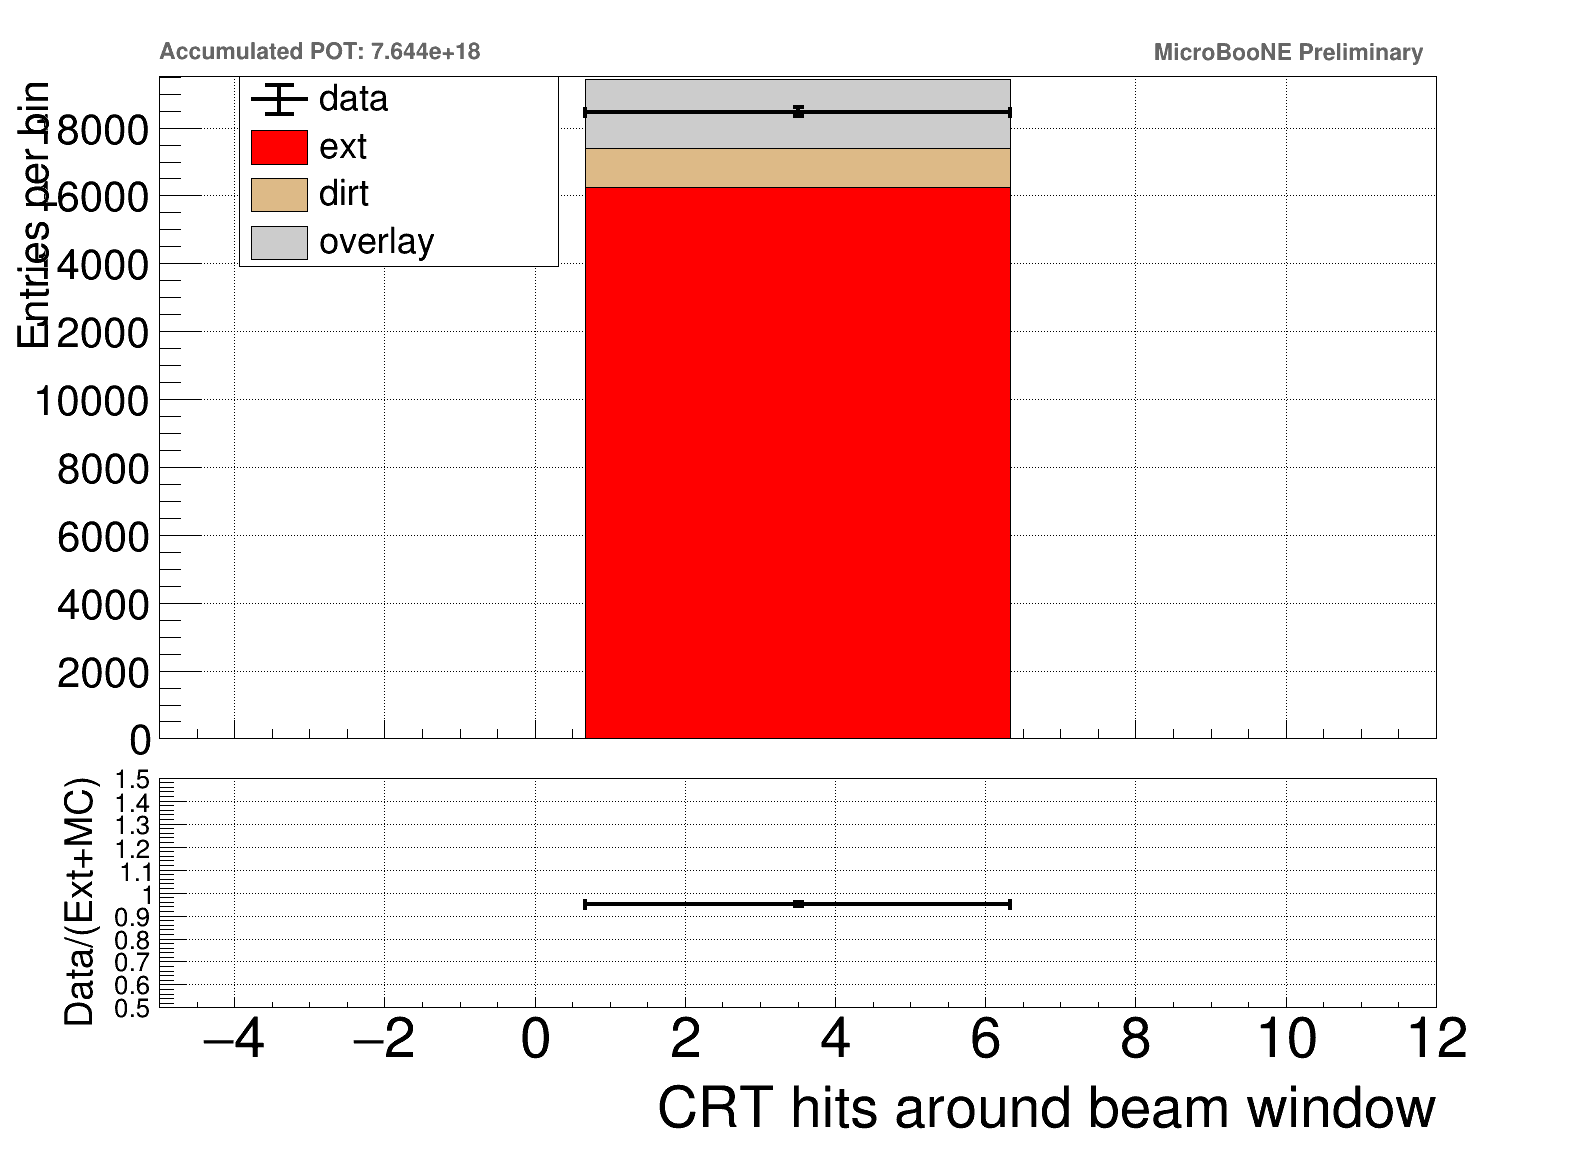

In [29]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 3
xstart = -5
xend = 12
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

cut = 'crt_adc>70'
#cut = '1'

data.Draw('crthit_ts0>>h_data',cut)
ext.Draw('crthit_ts0-3.57+3.195>>h_ext',cut)
overlay.Draw('crthit_ts0>>h_overlay',cut,'')
dirt.Draw('crthit_ts0>>h_dirt',cut,'')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT hits around beam window")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

print 'Scale: ',h_data.Integral(xstart,xend)/(h_ext.Integral(xstart,xend)+h_dirt.Integral(xstart,xend)+h_overlay.Integral(xstart,xend))


c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_time_corr_all.png")
c1.SaveAs(outputdir_root + "h_crt_time_corr_all.root")
c1.SaveAs(outputdir_pdf + "h_crt_time_corr_all.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_time_corr_top_cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_time_corr_top_cut.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_

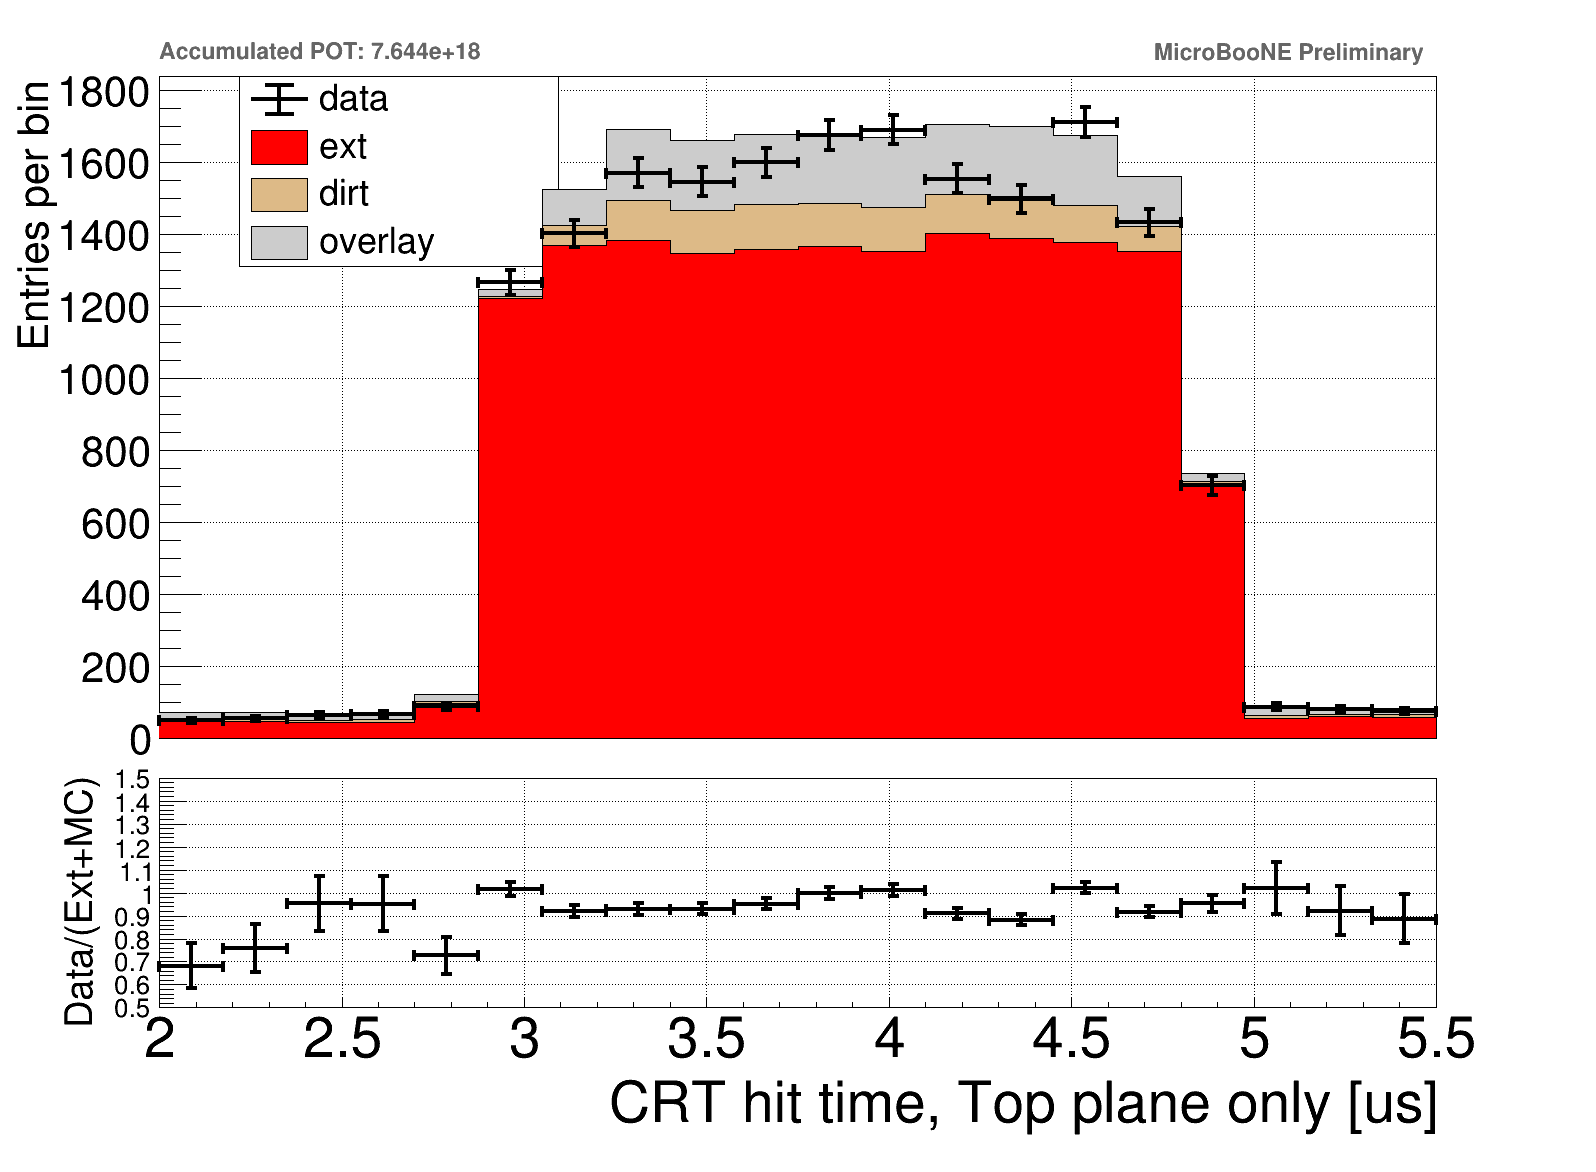

In [30]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 20
xstart = 2
xend = 5.5
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

cut = 'crt_adc>70'#nr_crthit_top == 1 && 

data_out.Draw('crthit_ts0>>h_data',cut)
ext_out.Draw('crthit_ts0-3.57+3.195>>h_ext',cut)
overlay_out.Draw('crthit_ts0>>h_overlay',cut,'')
dirt_out.Draw('crthit_ts0>>h_dirt',cut,'')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT hit time, Top plane only [us]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_time_corr_top_cut.png")
c1.SaveAs(outputdir_root + "h_crt_time_corr_top_cut.root")
c1.SaveAs(outputdir_pdf + "h_crt_time_corr_top_cut.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crtt0_time_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crtt0_time_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xse

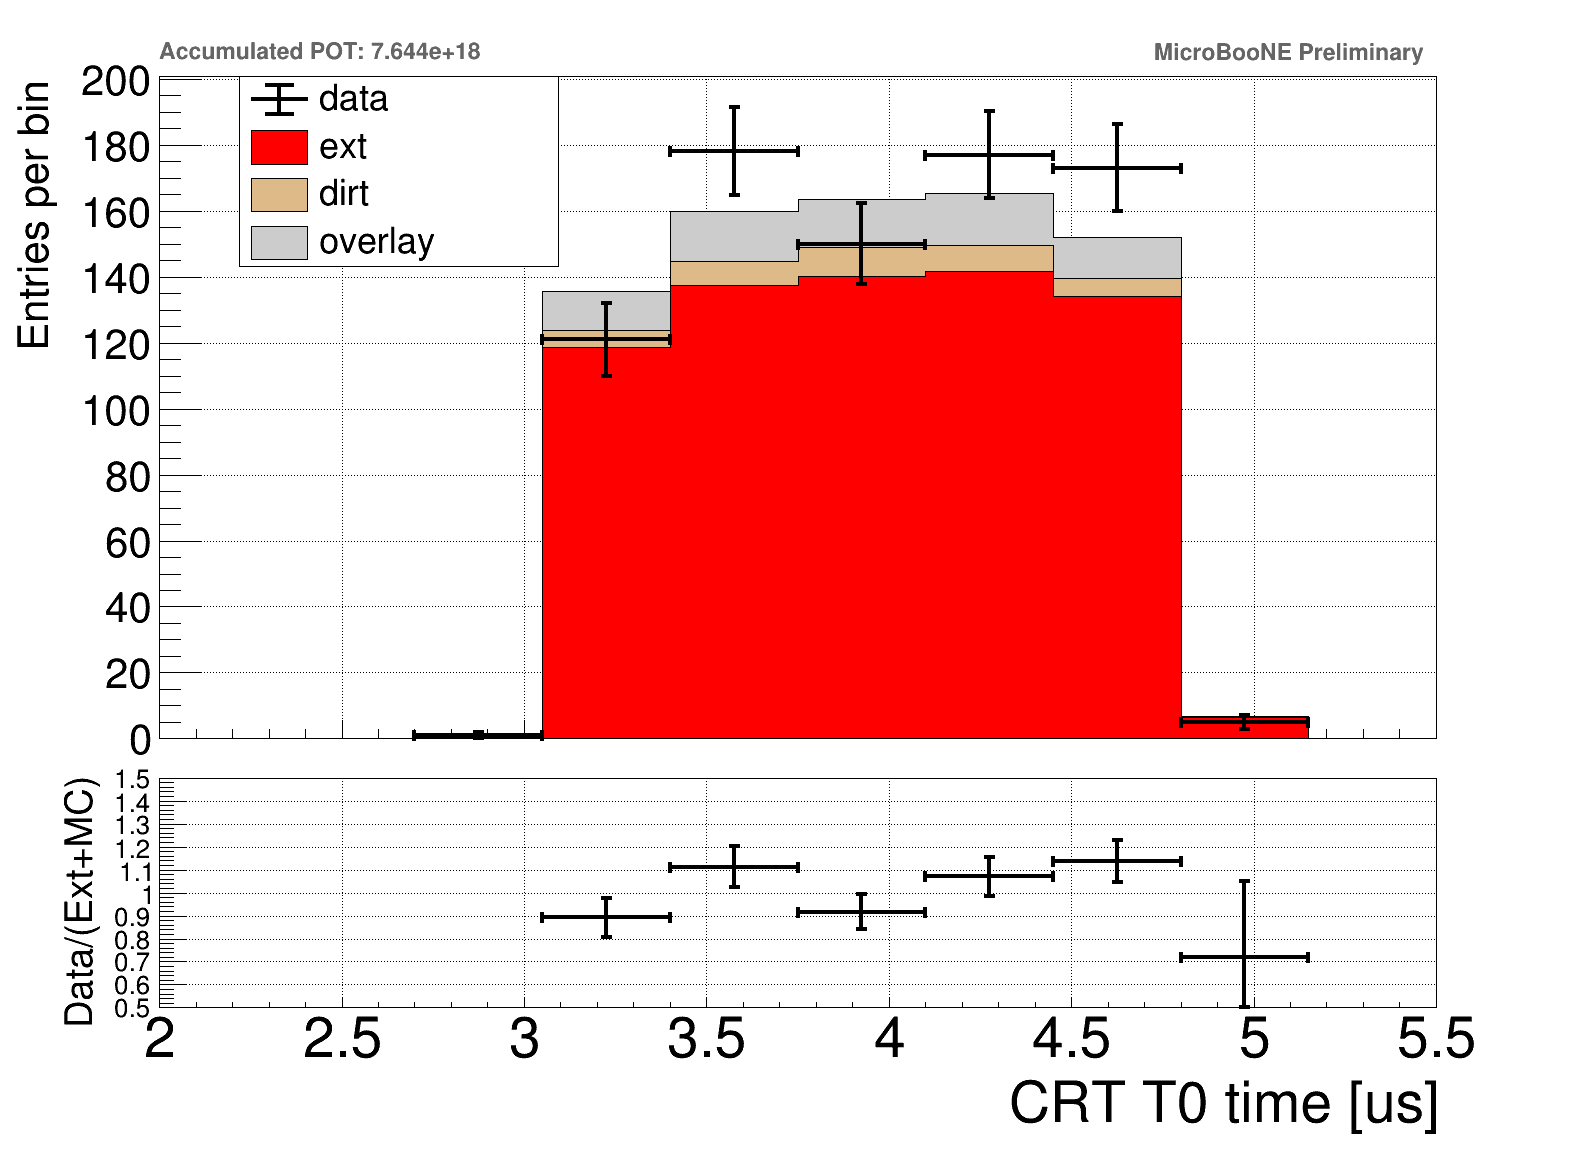

In [31]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'crtt0 time'
xbins = 10
xstart = 2
xend = 5.5
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)


data.Draw('crtt0_time+(crt_trig_corr_med)/1000>>h_data','crtt0_time!=-1')
ext.Draw('crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195>>h_ext','crtt0_time!=-1')
overlay.Draw('crtt0_time>>h_overlay','crtt0_time!=-1','')
dirt.Draw('crtt0_time>>h_dirt','crtt0_time!=-1','')

h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT T0 time [us]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crtt0_time_corr.png")
c1.SaveAs(outputdir_root + "h_crtt0_time_corr.root")
c1.SaveAs(outputdir_pdf + "h_crtt0_time_corr.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crtt0_time_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crtt0_time_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xse

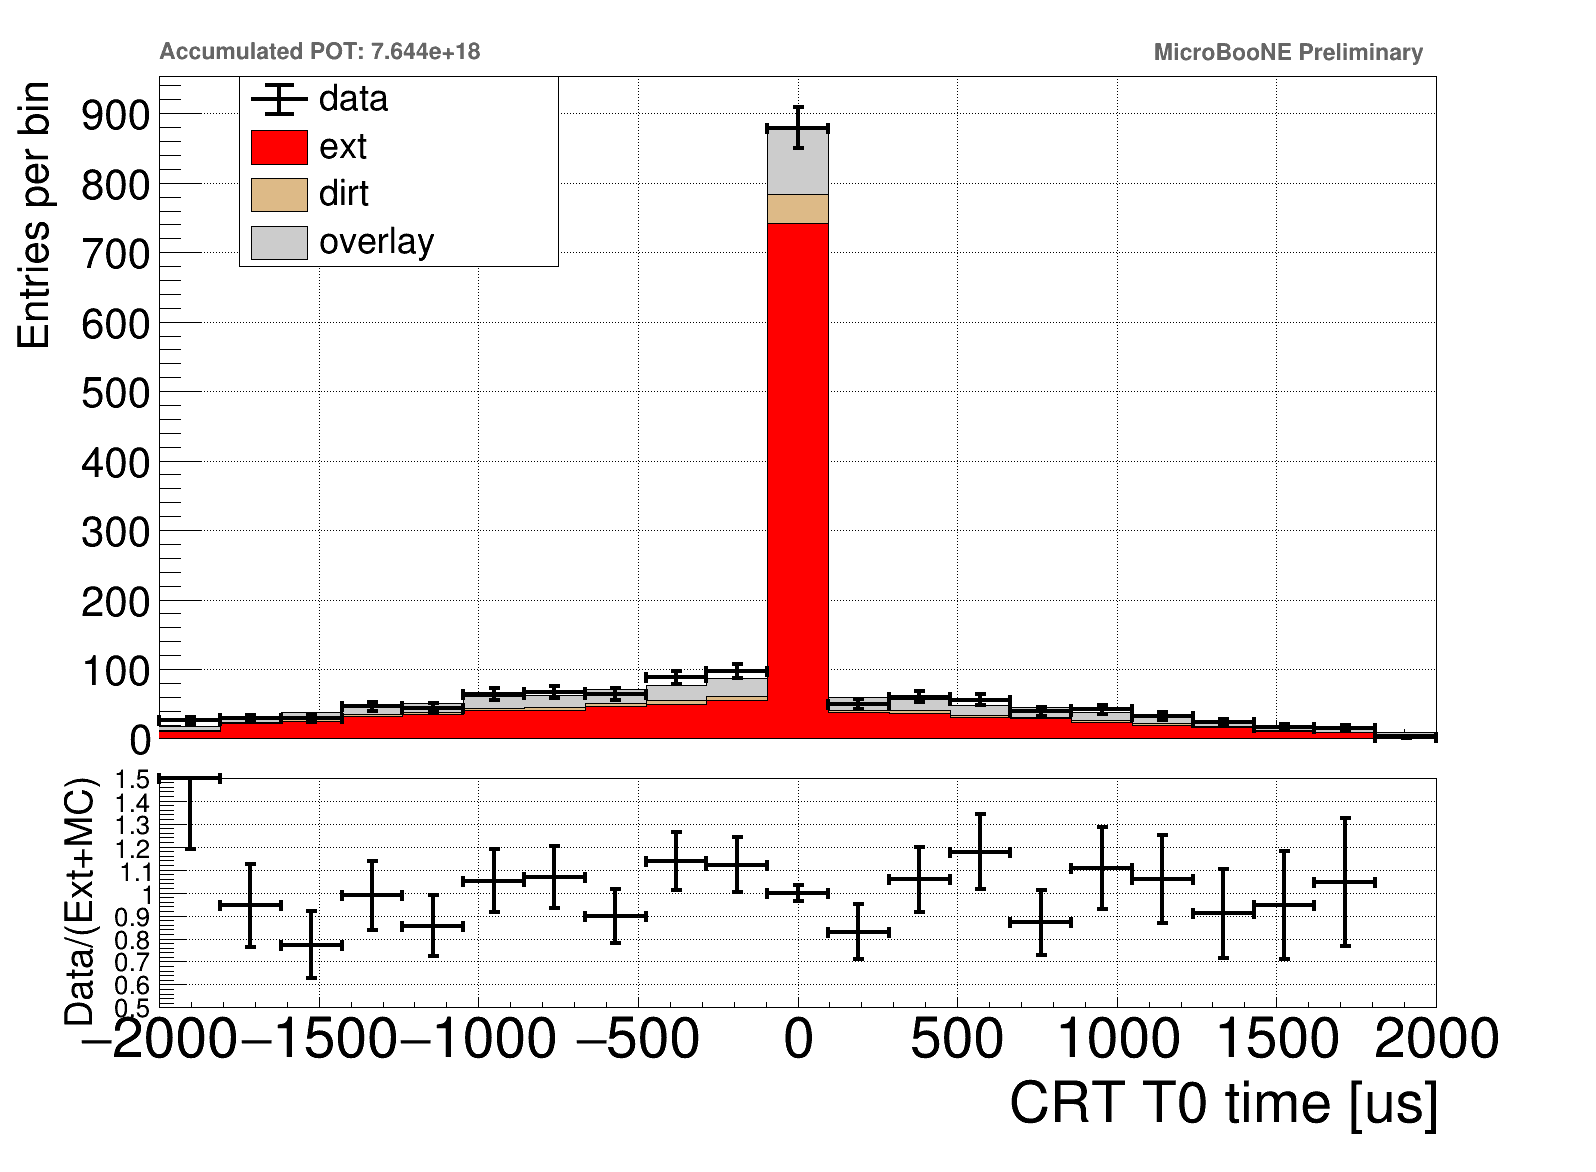

In [32]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'crtt0 time'
xbins = 21
xstart = -2000
xend = 2000
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)


data.Draw('crtt0_time+(crt_trig_corr_med)/1000>>h_data','crtt0_time!=-1')
ext.Draw('crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195>>h_ext','crtt0_time!=-1')
overlay.Draw('crtt0_time>>h_overlay','crtt0_time!=-1','')
dirt.Draw('crtt0_time>>h_dirt','crtt0_time!=-1','')

h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT T0 time [us]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crtt0_time_corr.png")
c1.SaveAs(outputdir_root + "h_crtt0_time_corr.root")
c1.SaveAs(outputdir_pdf + "h_crtt0_time_corr.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_PE_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_time_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_

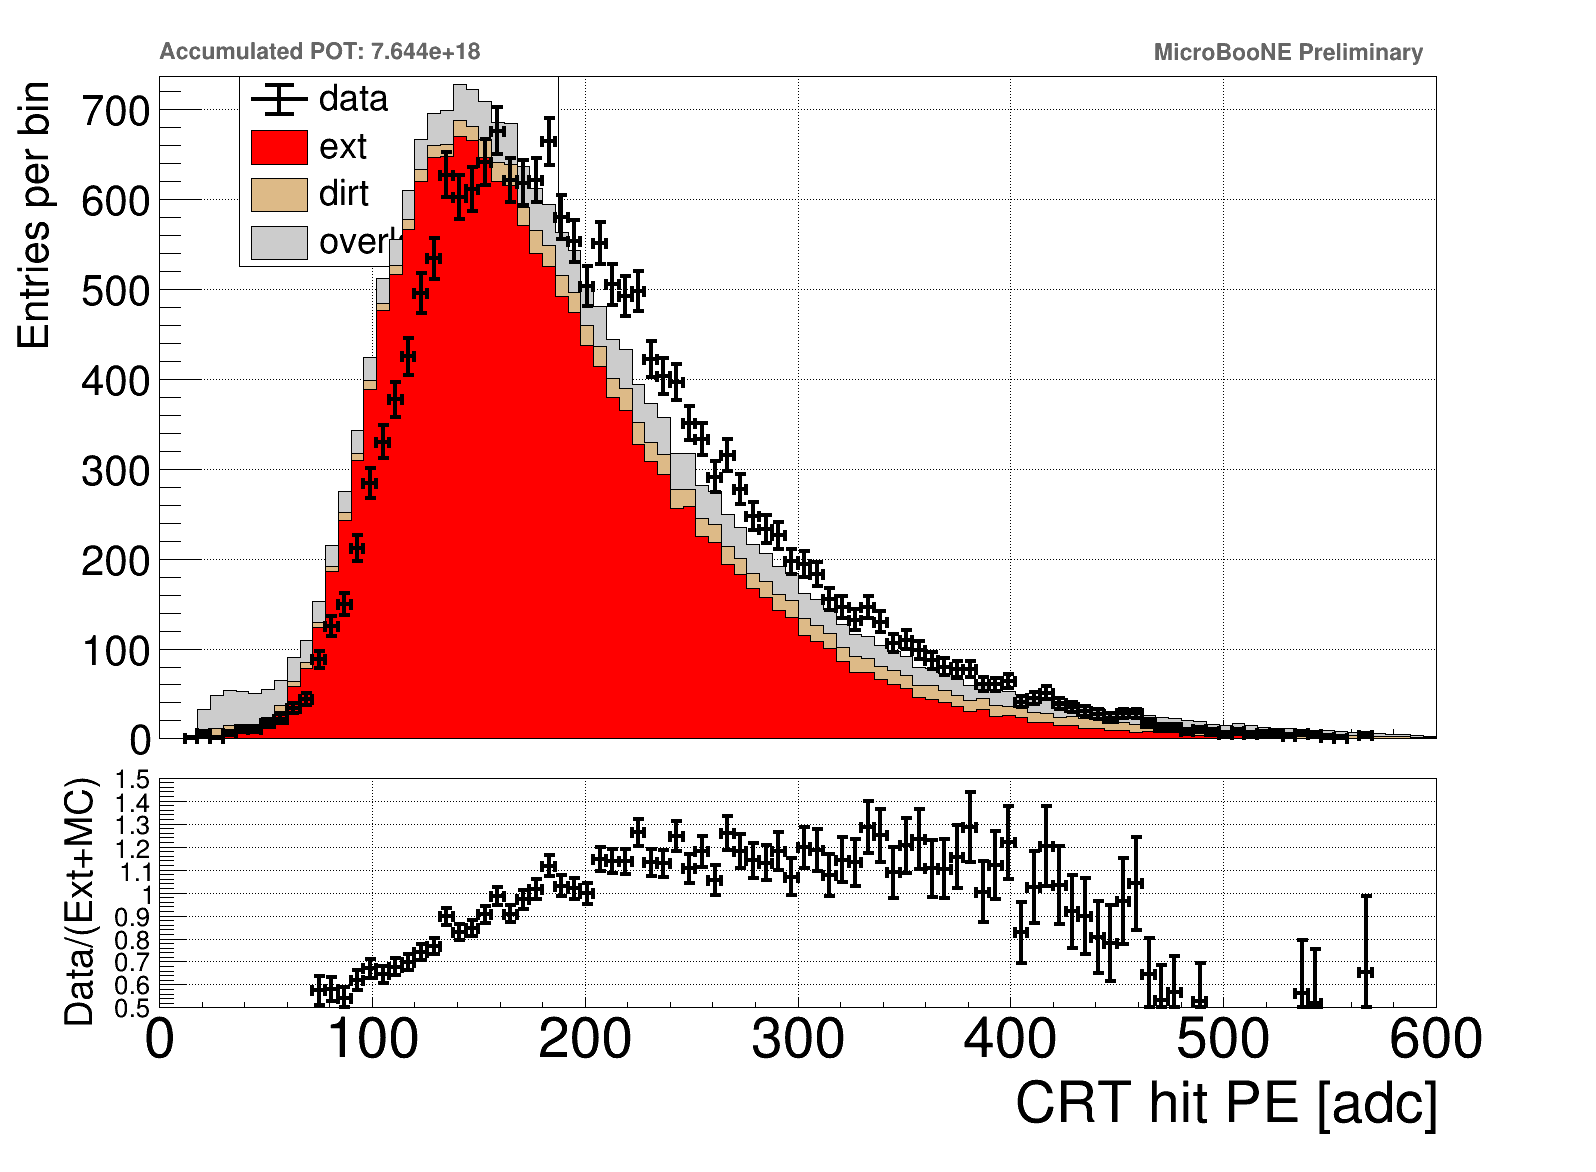

In [33]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 100
xstart = 0
xend = 600
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

cut = '1'
#cut = '1'

data.Draw('crt_adc>>h_data',cut)
ext.Draw('crt_adc>>h_ext',cut+'&& 1')
overlay.Draw('crt_adc>>h_overlay',cut,'')
dirt.Draw('crt_adc>>h_dirt',cut,'')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("CRT hit PE [adc]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_PE_corr.png")
c1.SaveAs(outputdir_root + "h_crt_time_corr.root")
c1.SaveAs(outputdir_pdf + "h_crt_time_corr.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Error in <TGaxis::PaintAxis>: Time offset has not the right format
Error in <TGaxis::PaintAxis>: Time offset has not the right format
Error in <TGaxis::PaintAxis>: Time offset has not the right format
Error in <TGaxis::PaintAxis>: Time offset has not the right format
Error in <TGaxis::PaintAxis>: Time offset has not the right format
Error in <TGaxis::PaintAxis>: Time offset has not the right format
Error in <TGaxis::Paint

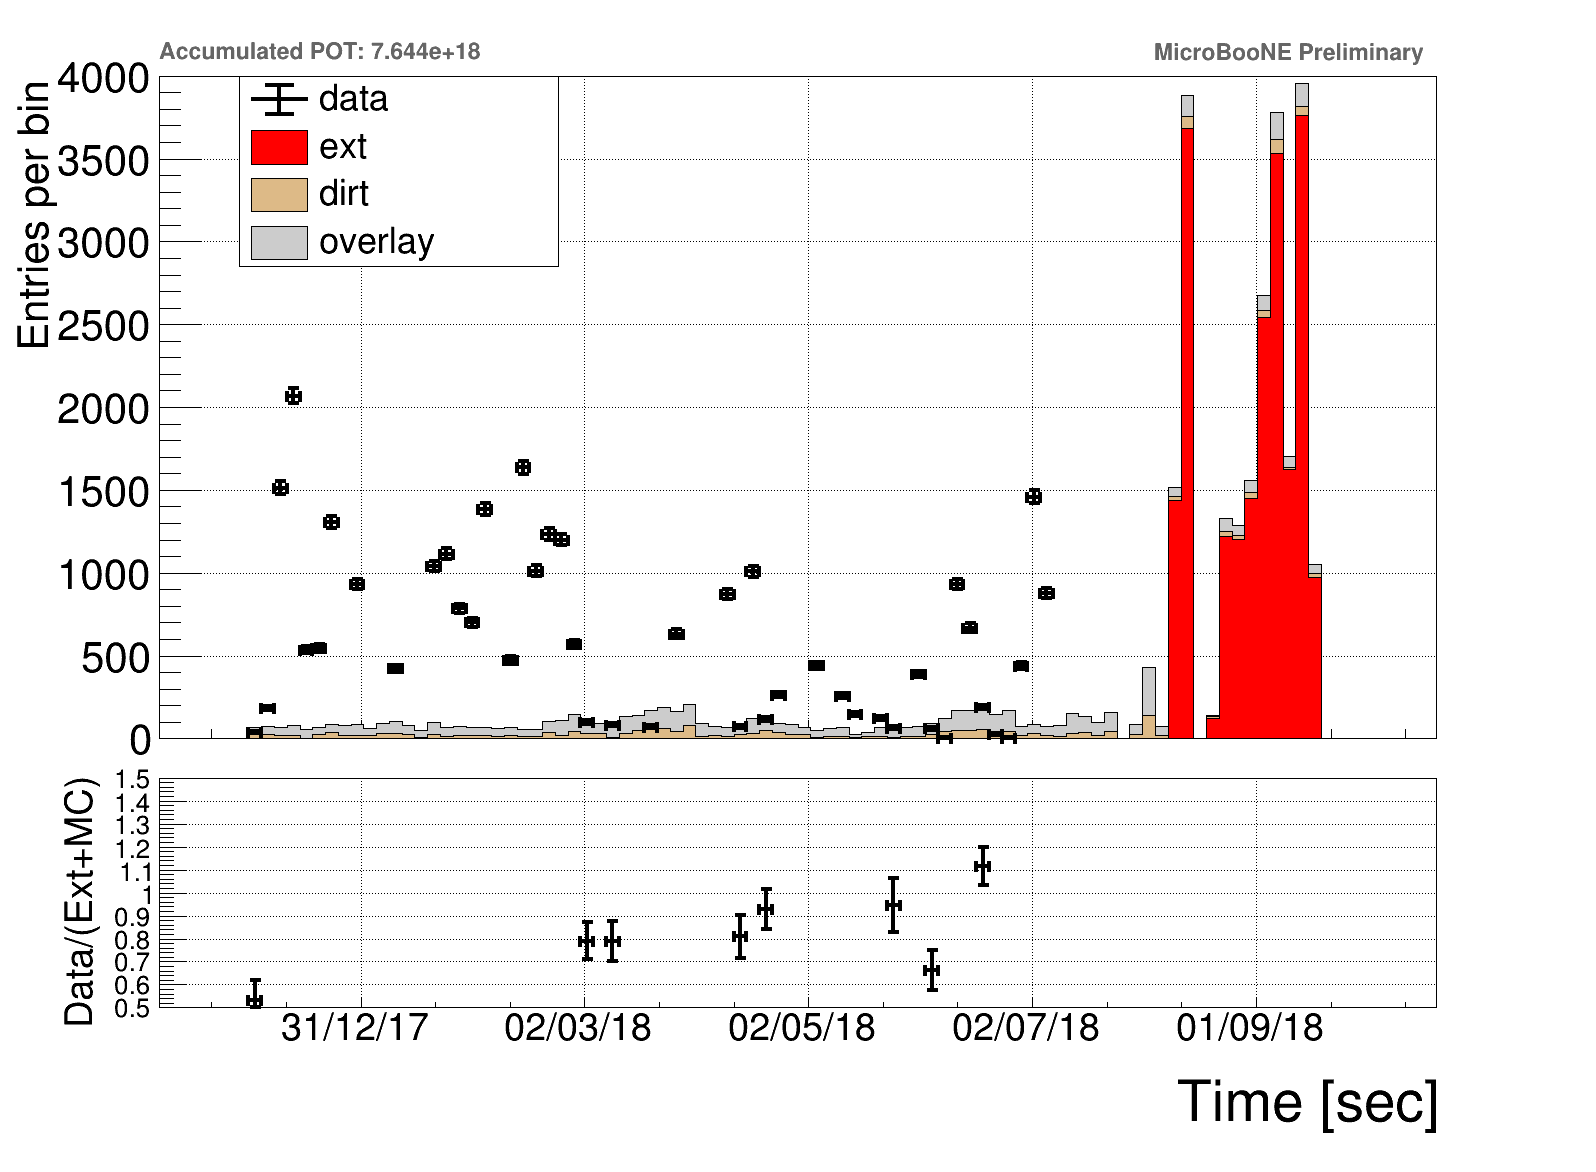

In [34]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 100
xstart = 1510e6
xend = 1540e6
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

cut = '1'
#cut = '1'

data.Draw('TriTim_sec>>h_data',cut)
ext.Draw('TriTim_sec>>h_ext',cut+'&& 1')
overlay.Draw('TriTim_sec>>h_overlay',cut,'')
dirt.Draw('TriTim_sec>>h_dirt',cut,'')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("Time [sec]")

h_data.GetYaxis().SetLabelSize(0.06);
h_data.GetYaxis().SetTitleSize(0.06);
h_data.GetYaxis().SetTitleOffset(0.8);
#ROOT.gStyle.SetLabelSize(0.5, 'Y');
h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)


#h_data.SetMarkerStyle(ROOT.kFullCircle);
#h_data.SetMarkerSize(0.9);
#h_data.SetFillStyle(3005);
#ROOT.gStyle.SetErrorX(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.SetMaximum(4000)
h_data.GetXaxis().SetTimeDisplay(1)
h_data.GetXaxis().SetTimeFormat("%d/%m/%y %F1970-01-01")
h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
#prelim.SetTextSize(0.04631579);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
#pad2.SetFillStyle(4000);
#pad2.SetFrameFillStyle(4000);

#pad2.SetFrameBorderMode(0);
#pad2.SetBorderMode(0);
#pad2.SetBorderSize(0);
pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTimeDisplay(1)
h_div_func.GetXaxis().SetTimeFormat("%d/%m/%y %F1970-01-01")
h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.1)
h_div_func.GetXaxis().SetTitleOffset(1)

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_event_time.png")
c1.SaveAs(outputdir_root + "h_event_time.root")
c1.SaveAs(outputdir_pdf + "h_event_time.pdf")

# difference for cut metrics:

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_nr_top.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_nr_top.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/

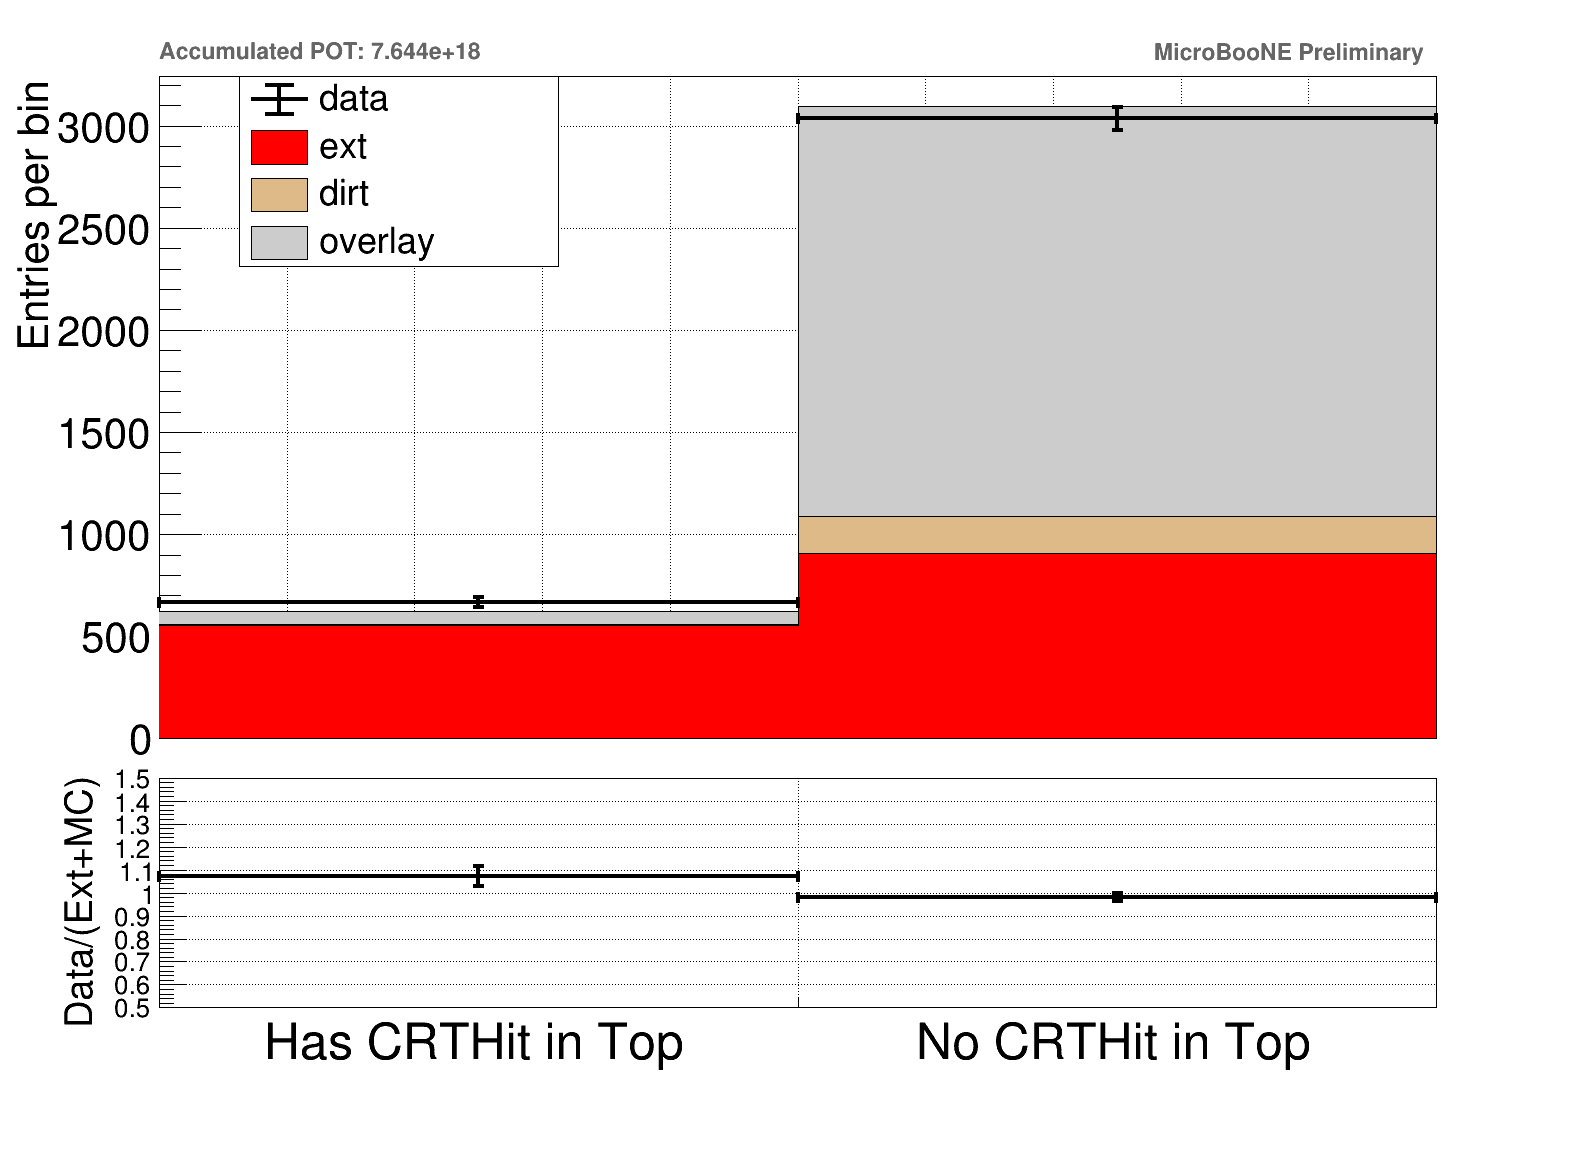

In [35]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
xbins = 2
xstart = 0
xend = 2
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

#cut = 'crt_adc>70'
cut = 'fidVol'

data_out.Draw('(nr_crthit_top==0)>>h_data',cut)
ext_out.Draw('(nr_crthit_top==0)>>h_ext',cut)
overlay_out.Draw('(nr_crthit_top)==0>>h_overlay',weight_name+'*('+cut+')','')
dirt_out.Draw('(nr_crthit_top)==0>>h_dirt',weight_name+'*('+cut+')','')


h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1), pad1.Draw(), pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("Number of CRT hits in top plane")

h_data.GetYaxis().SetLabelSize(0.06), h_data.SetMinimum(0)
h_data.GetYaxis().SetTitleSize(0.06), h_data.GetYaxis().SetTitleOffset(0.8), h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999), h_data.GetXaxis().SetLabelSize(0), h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03), pad1.SetTopMargin(0.1)

h_data.SetLineColor(ROOT.kBlack), h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62), prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC(), prelim.SetTextSize(1/30.), prelim.SetTextAlign(32);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1), pad2.SetTopMargin(0.04), pad2.SetBottomMargin(0.4)

pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(-999)
h_div_func.GetXaxis().SetLabelOffset(0.02)
h_div_func.GetXaxis().SetLabelSize(0.2)
h_div_func.GetXaxis().SetBinLabel(1, 'Has CRTHit in Top')
h_div_func.GetXaxis().SetBinLabel(2, 'No CRTHit in Top')

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_nr_top.png")
c1.SaveAs(outputdir_root + "h_crt_nr_top.root")
c1.SaveAs(outputdir_pdf + "h_crt_nr_top.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_upstream.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_upstream.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_

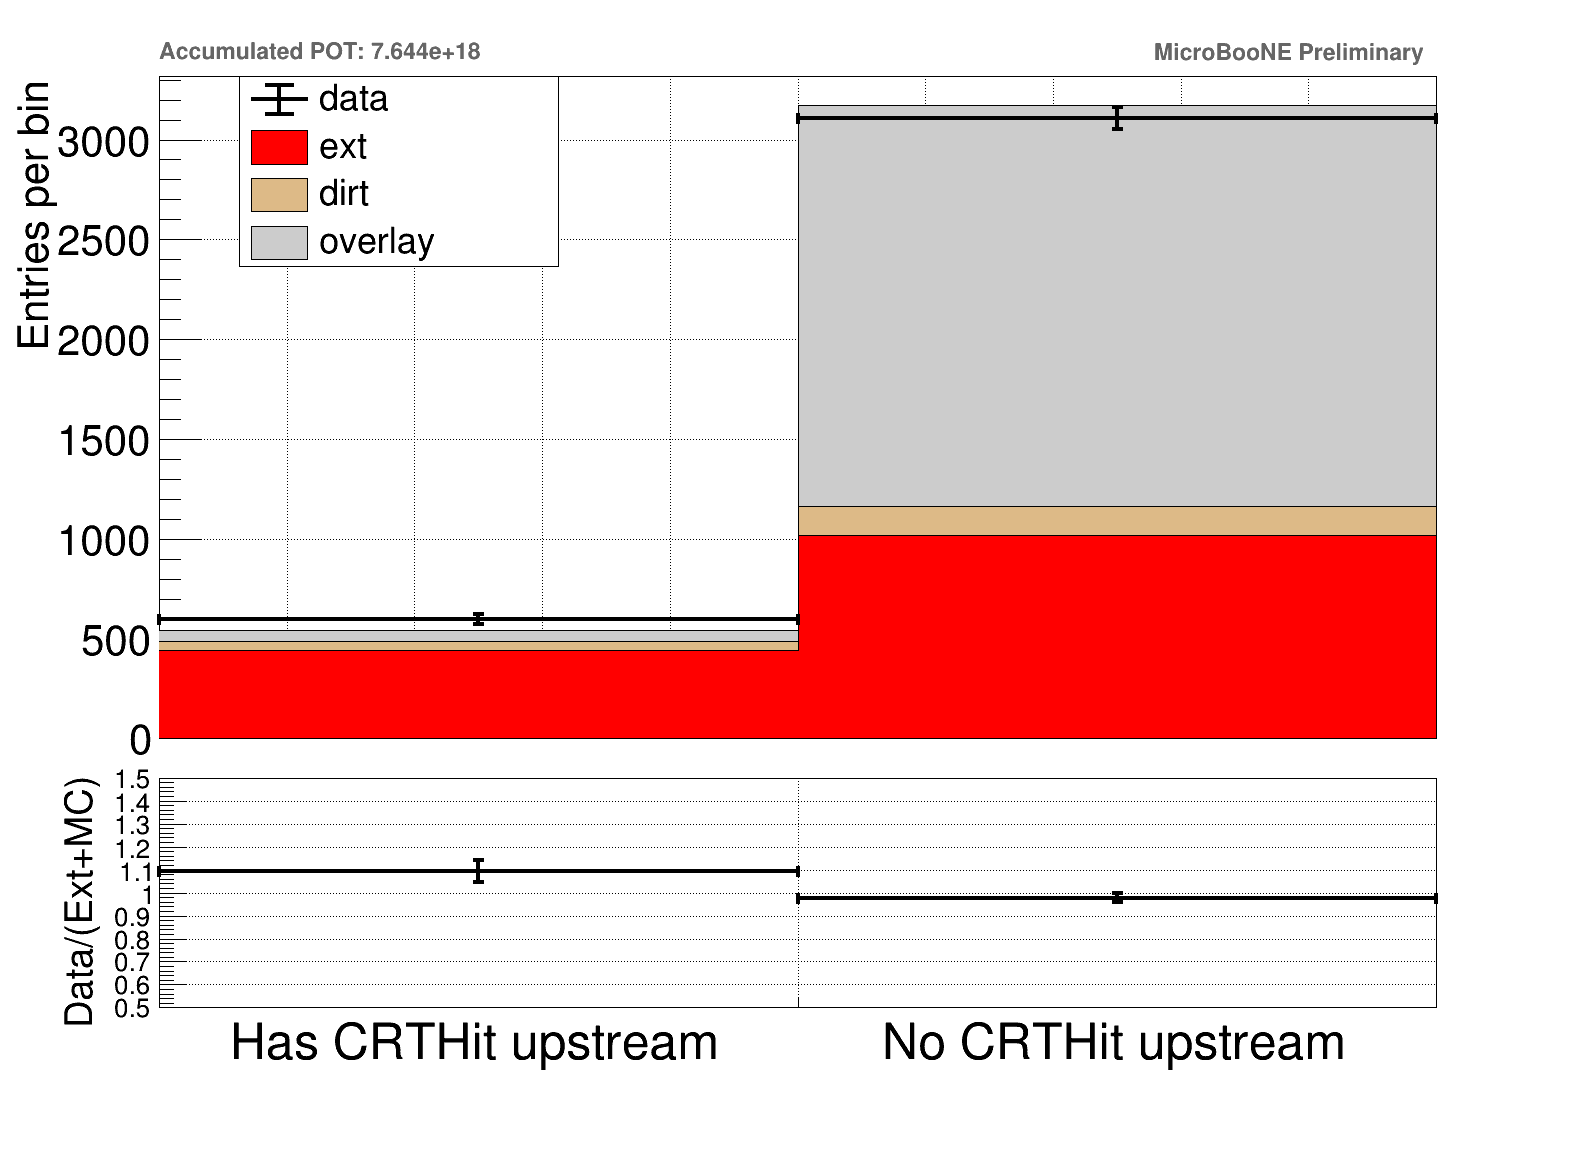

In [36]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
weight_name = 'EventWeight*TunedCentralValue_Genie'
xbins = 2
xstart = 0
xend = 2
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

#cut = 'crt_adc>70'
cut = 'fidVol'

data_out.Draw('crthit_vertex_zcut==0>>h_data',cut)
ext_out.Draw('crthit_vertex_zcut==0>>h_ext',cut)
overlay_out.Draw('crthit_vertex_zcut==0>>h_overlay',weight_name+'*('+cut+')','')
dirt_out.Draw('crthit_vertex_zcut==0>>h_dirt',weight_name+'*('+cut+')','')

h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1), pad1.Draw(), pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("Vertex is downstream")

h_data.GetYaxis().SetLabelSize(0.06), h_data.SetMinimum(0)
h_data.GetYaxis().SetTitleSize(0.06), h_data.GetYaxis().SetTitleOffset(0.8), h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999), h_data.GetXaxis().SetLabelSize(0), h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03), pad1.SetTopMargin(0.1)

h_data.SetLineColor(ROOT.kBlack), h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62), prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC(), prelim.SetTextSize(1/30.), prelim.SetTextAlign(32);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1), pad2.SetTopMargin(0.04), pad2.SetBottomMargin(0.4)

pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(-999)
h_div_func.GetXaxis().SetLabelOffset(0.02)
h_div_func.GetXaxis().SetLabelSize(0.2)
h_div_func.GetXaxis().SetBinLabel(1, 'Has CRTHit upstream')
h_div_func.GetXaxis().SetBinLabel(2, 'No CRTHit upstream')

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_upstream.png")
c1.SaveAs(outputdir_root + "h_crt_upstream.root")
c1.SaveAs(outputdir_pdf + "h_crt_upstream.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_cont_veto.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_cont_veto.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_cr

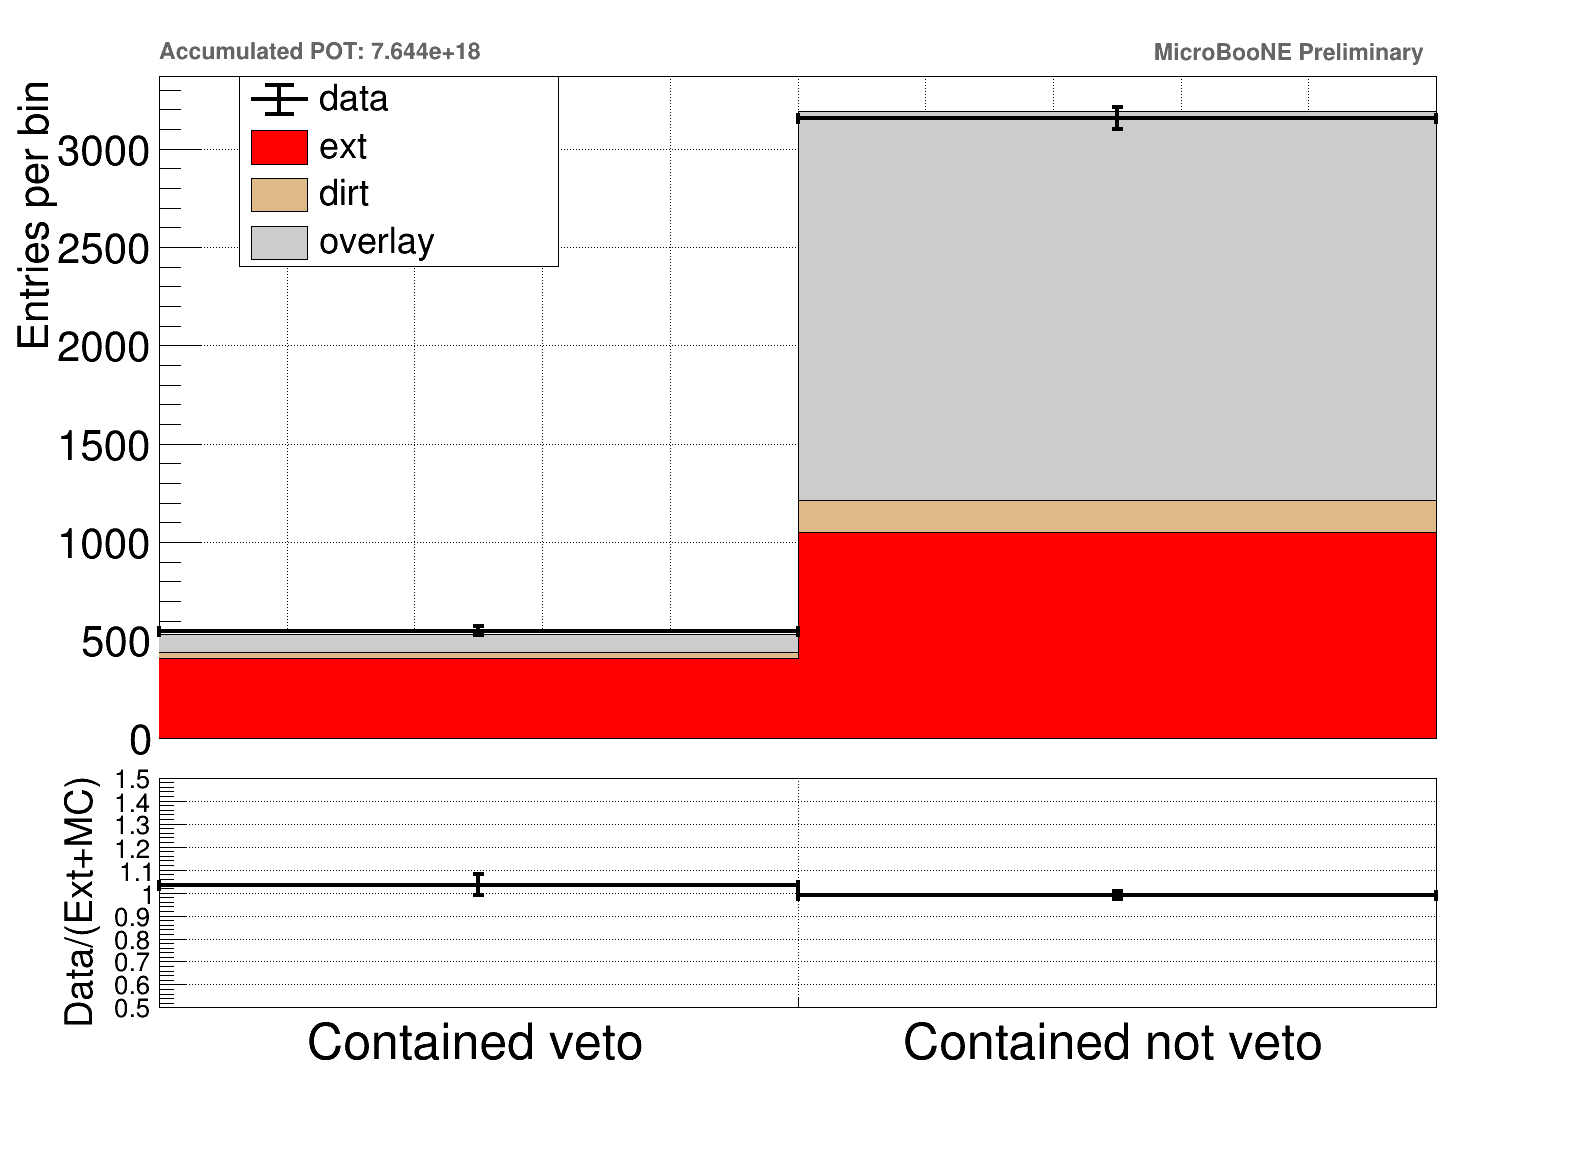

In [37]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
weight_name = 'EventWeight*TunedCentralValue_Genie'
xbins = 2
xstart = 0
xend = 2
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

#cut = 'crt_adc>70'
cut = 'fidVol'

data_out.Draw('(track_end_uncontained==1 || nr_crthit_beam_tres==0)>>h_data',cut)
ext_out.Draw('(track_end_uncontained==1 || nr_crthit_beam_tres==0)>>h_ext',cut)
overlay_out.Draw('(track_end_uncontained==1 || nr_crthit_beam_tres==0)>>h_overlay',weight_name+'*('+cut+')','')
dirt_out.Draw('(track_end_uncontained==1 || nr_crthit_beam_tres==0)>>h_dirt',weight_name+'*('+cut+')','')

h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1), pad1.Draw(), pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("Vertex is downstream")

h_data.GetYaxis().SetLabelSize(0.06), h_data.SetMinimum(0)
h_data.GetYaxis().SetTitleSize(0.06), h_data.GetYaxis().SetTitleOffset(0.8), h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999), h_data.GetXaxis().SetLabelSize(0), h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03), pad1.SetTopMargin(0.1)

h_data.SetLineColor(ROOT.kBlack), h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62), prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC(), prelim.SetTextSize(1/30.), prelim.SetTextAlign(32);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1), pad2.SetTopMargin(0.04), pad2.SetBottomMargin(0.4)

pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(-999)
h_div_func.GetXaxis().SetLabelOffset(0.02)
h_div_func.GetXaxis().SetLabelSize(0.2)
h_div_func.GetXaxis().SetBinLabel(1, 'Contained veto')
h_div_func.GetXaxis().SetBinLabel(2, 'Contained not veto')

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_cont_veto.png")
c1.SaveAs(outputdir_root + "h_crt_cont_veto.root")
c1.SaveAs(outputdir_pdf + "h_crt_cont_veto.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_overlay (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/h_crt_crt_cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/h_crt_crt_cut.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sy

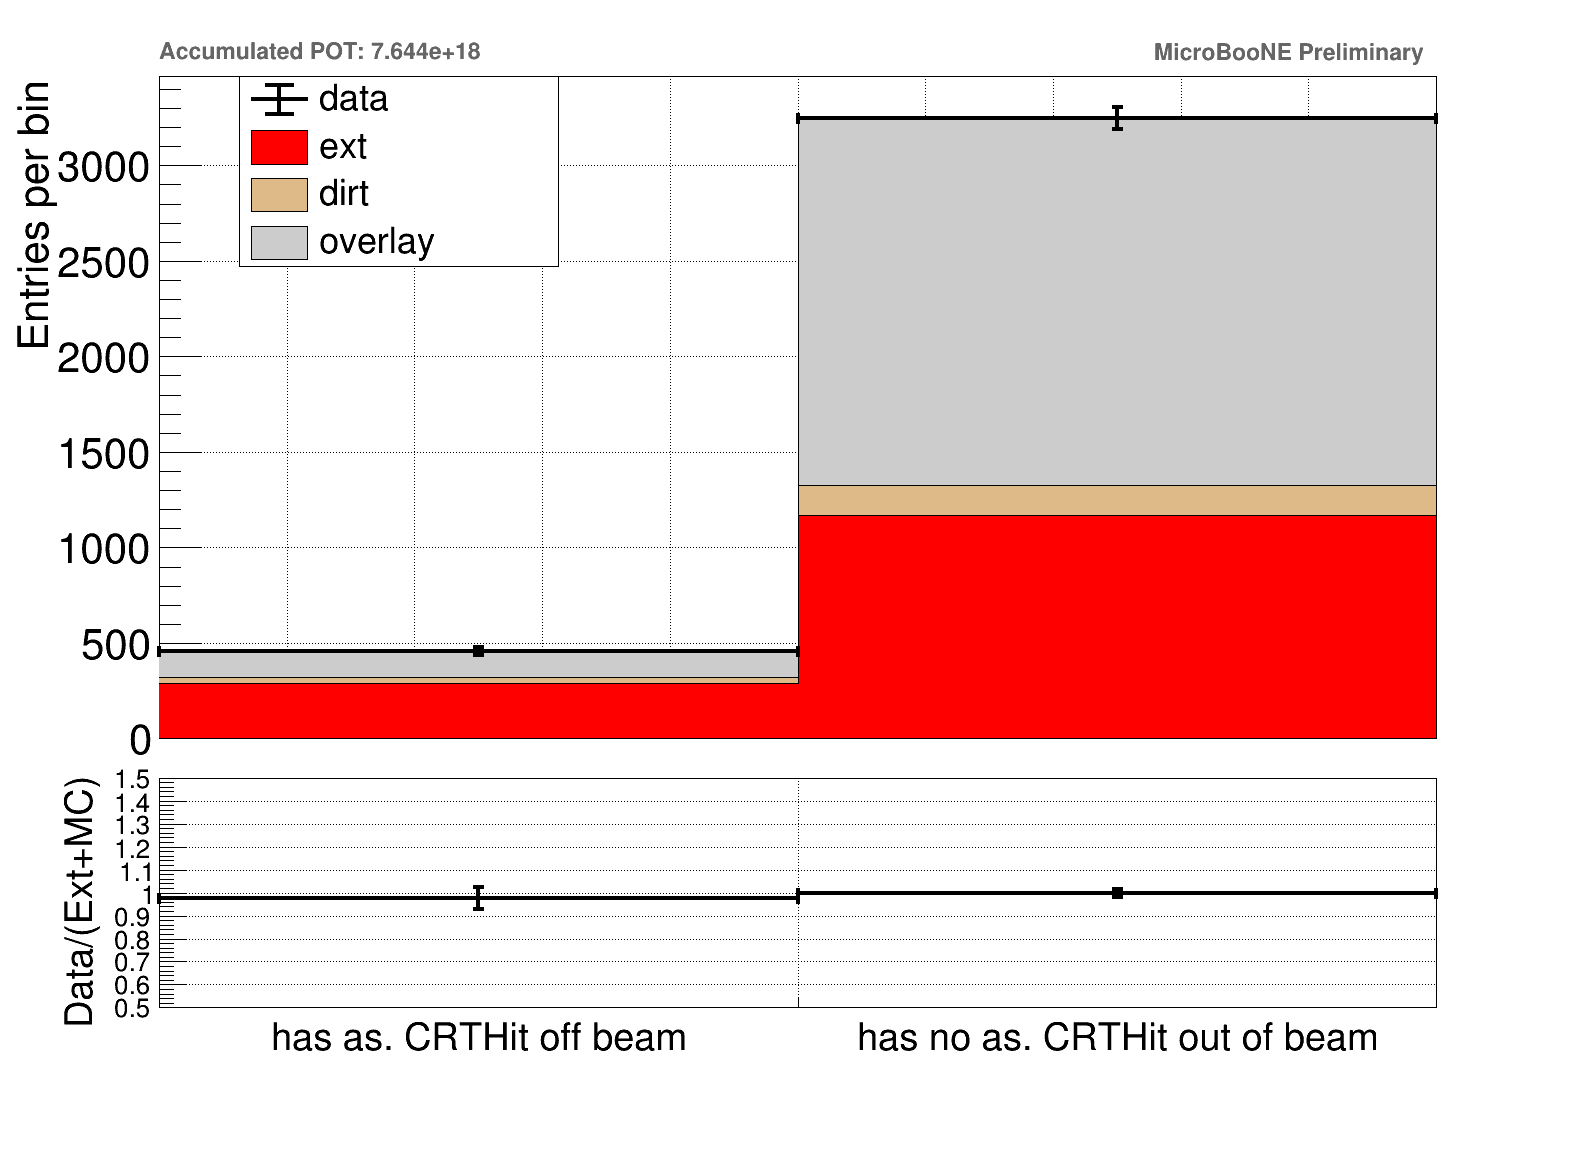

In [38]:
#overlay.Draw('crtt0_time>>h(100,2,6)')
#data.Draw('crthit_ts0>>h(100,2,6)')
title = 'CRT hit time'
weight_name = 'EventWeight*TunedCentralValue_Genie'
xbins = 2
xstart = 0
xend = 2
h_data = ROOT.TH1F("h_data",title,xbins,xstart,xend)
h_ext = ROOT.TH1F("h_ext",title,xbins,xstart,xend)
h_dirt = ROOT.TH1F("h_dirt",title,xbins,xstart,xend)
h_overlay = ROOT.TH1F("h_overlay",title,xbins,xstart,xend)

#cut = 'crt_adc>70'
cut = 'fidVol'

data_out.Draw('crt_cut>>h_data',cut)
ext_out.Draw('crt_cut>>h_ext',cut)
overlay_out.Draw('crt_cut>>h_overlay',weight_name+'*('+cut+')','')
dirt_out.Draw('crt_cut>>h_dirt',weight_name+'*('+cut+')','')

h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_ext.SetFillColor(2)
h_ext.SetLineColor(1)
h_dirt.SetFillColor(42)
h_dirt.SetLineColor(1)
h_overlay.SetFillColor(ROOT.kGray)
h_overlay.SetLineColor(1)
#h_overlay.SetLineWidth(3)

#legend = ROOT.TLegend(0.75,0.65,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.65,0.35,0.9) # LEGEND LEFT
legend.AddEntry(h_data,"data","lep");
legend.AddEntry(h_ext,"ext","f");
legend.AddEntry(h_dirt,"dirt","f");
legend.AddEntry(h_overlay,"overlay","f");

c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1), pad1.Draw(), pad1.cd()

hs = ROOT.THStack("hs","");
hs.Add(h_ext)
hs.Add(h_dirt)
hs.Add(h_overlay)
h_data.SetYTitle("Entries per bin")
h_data.SetXTitle("Vertex is downstream")

h_data.GetYaxis().SetLabelSize(0.06), h_data.SetMinimum(0)
h_data.GetYaxis().SetTitleSize(0.06), h_data.GetYaxis().SetTitleOffset(0.8), h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999), h_data.GetXaxis().SetLabelSize(0), h_data.GetXaxis().SetTitleSize(0);
pad1.SetBottomMargin(0.03), pad1.SetTopMargin(0.1)

h_data.SetLineColor(ROOT.kBlack), h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

h_data.Draw('E1')
legend.Draw()
hs.Draw('hist same')
h_data.Draw('same E1')

prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
prelim.SetTextFont(62), prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC(), prelim.SetTextSize(1/30.), prelim.SetTextAlign(32);
prelim.Draw()

pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
pot_latex.SetTextFont(62);
pot_latex.SetTextColor(ROOT.kGray+2);
pot_latex.SetNDC();
pot_latex.SetTextSize(1/30.);
pot_latex.SetTextAlign(10) #;//left adjusted
pot_latex.Draw();

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);
#h_data.GetXaxis().SetLabelSize(0.06);
#pad2 = ROOT.TPad('pad2','pad2',0,0.05,1,0.33)
pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1), pad2.SetTopMargin(0.04), pad2.SetBottomMargin(0.4)

pad2.Draw()
pad2.cd()
h_tot_func = h_ext.Clone()
h_div_func = h_data.Clone()
h_tot_func.Add(h_dirt)
h_tot_func.Add(h_overlay)
h_div_func.Divide(h_tot_func )
h_div_func.SetMinimum(0.5)
h_div_func.SetMaximum(1.5)
h_div_func.SetYTitle('Data/(Ext+MC)')
h_div_func.GetYaxis().SetTitleSize(0.1)
h_div_func.GetYaxis().SetTitleOffset(0.3)
h_div_func.GetYaxis().SetLabelSize(0.07)

h_div_func.GetXaxis().SetTitleSize(0.15)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetTitleOffset(-999)
h_div_func.GetXaxis().SetLabelOffset(0.02)
h_div_func.GetXaxis().SetLabelSize(0.15)
h_div_func.GetXaxis().SetBinLabel(1, 'has as. CRTHit off beam')
h_div_func.GetXaxis().SetBinLabel(2, 'has no as. CRTHit out of beam')

h_div_func.Draw('E1')
c1.Draw()
c1.SaveAs(outputdir_png + "h_crt_crt_cut.png")
c1.SaveAs(outputdir_root + "h_crt_crt_cut.root")
c1.SaveAs(outputdir_root + "h_crt_crt_cut.pdf")

Normalization (data)/(mc +ext) =  1.11771804546
Normalization (data)/(mc +ext) =  1.11771850957
Normalization (data)/(mc +ext) =  1.11771851762
Normalization (data)/(mc +ext) =  1.11771953055


1.1177195305488703

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/CRTTophit_cut_preselection.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/CRTTophit_cut_preselection.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/pdf/CRTTophit_cut_preselection.pdf has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/CRTvertex_cut_preselection.png has been created
Info in <TCanvas::SaveAs>: ROOT 

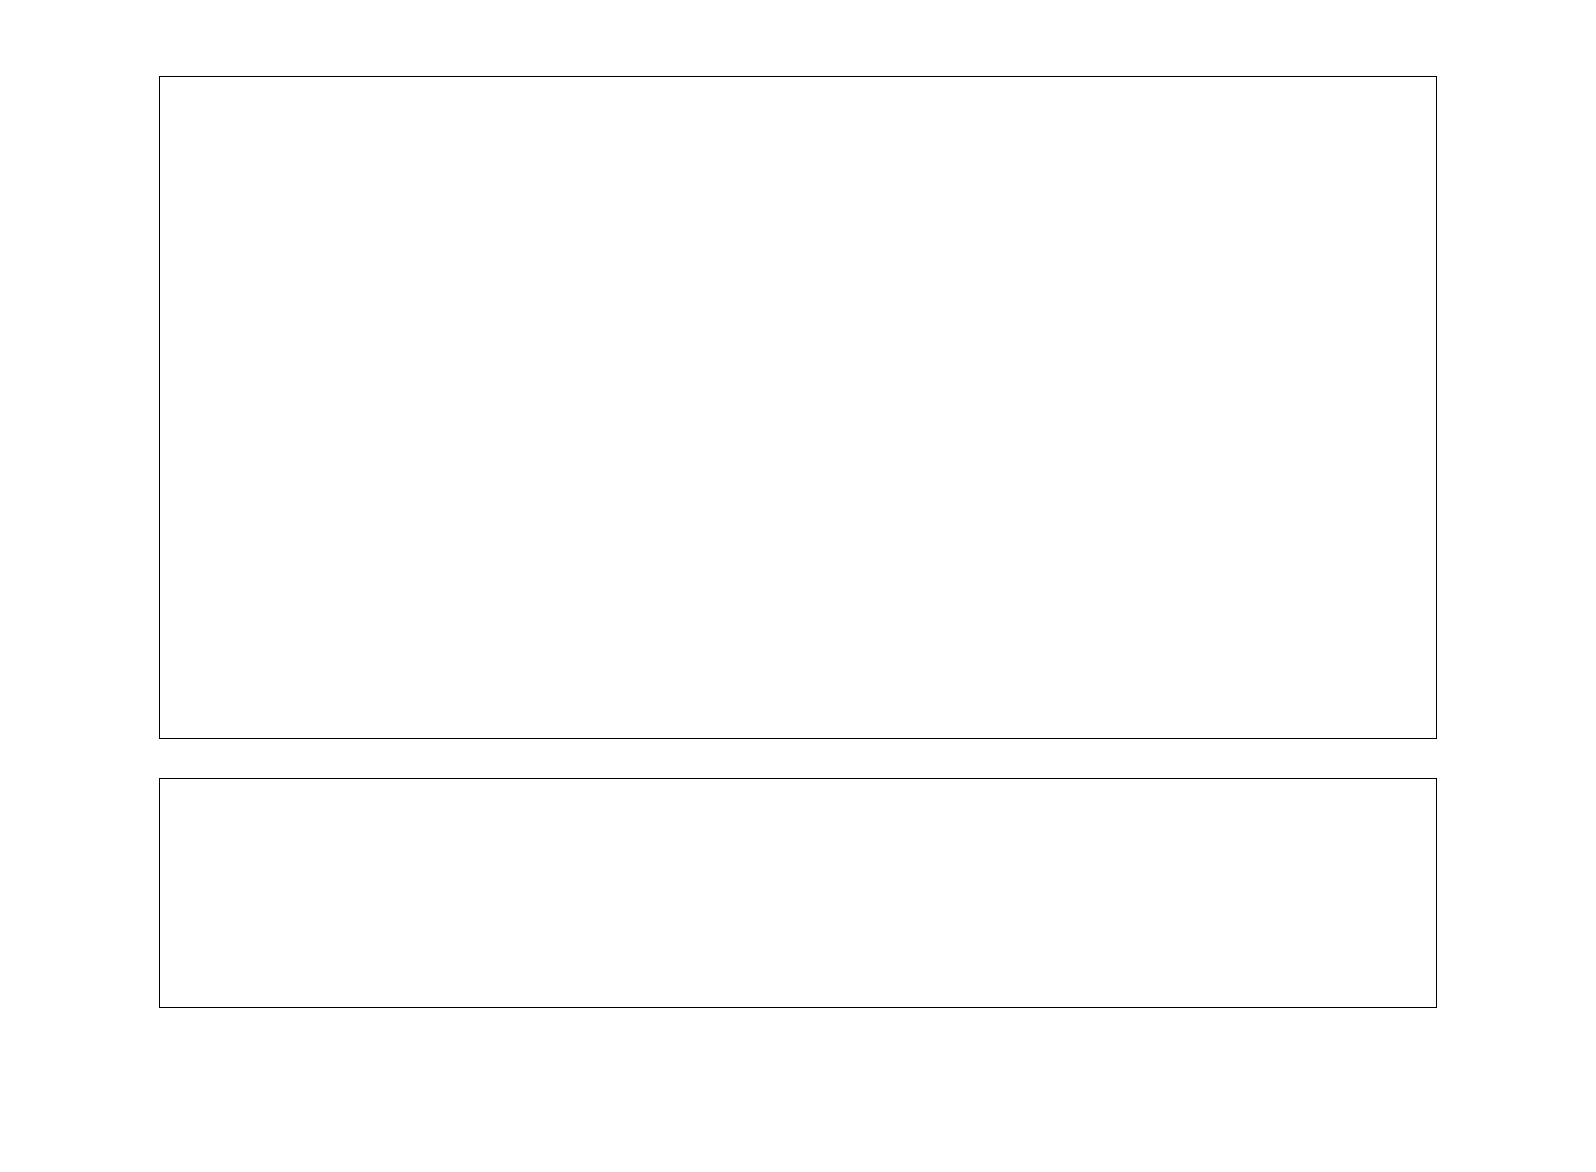

In [39]:
cut = 'fidVol && muon && TrackLength>8'
cut = 'fidVol'
name = '_preselection'
side_right = 'right'
side_left = 'left'
NuCC_w.make_stacked_histo_onoff(cut,'(nr_crthit_top==0)','EventWeight','nr_crthit_top',0,2,2,'CRTTophit_cut'+name,side_left,'has CRTHit in Top','has No CRTHit in Top')
NuCC_w.make_stacked_histo_onoff(cut,'(crthit_vertex_zcut==0)','EventWeight','nr_crthit_top',0,2,2,'CRTvertex_cut'+name,side_left,'has uptream CRTHit','has No upstreamCRTHit')
NuCC_w.make_stacked_histo_onoff(cut,'(track_end_uncontained==1 || nr_crthit_beam_tres==0)','EventWeight','nr_crthit_top',0,2,2,'CRTcontVeto_cut'+name,side_left,'Veto for cont. event','No Veto')
NuCC_w.make_stacked_histo_onoff(cut,'crt_cut','EventWeight','nr_crthit_top',0,2,2,'CRTAsso_cut'+name,side_left,'has as. CRTHit off beam','has No as. CRTHit off beam')




Normalization (data)/(mc +ext) =  1.11771804546


1.1177180454555138

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/png/CRTTophits_cut_precut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/root/CRTTophits_cut_precut.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_sys/pdf/CRTTophits_cut_precut.pdf has been created


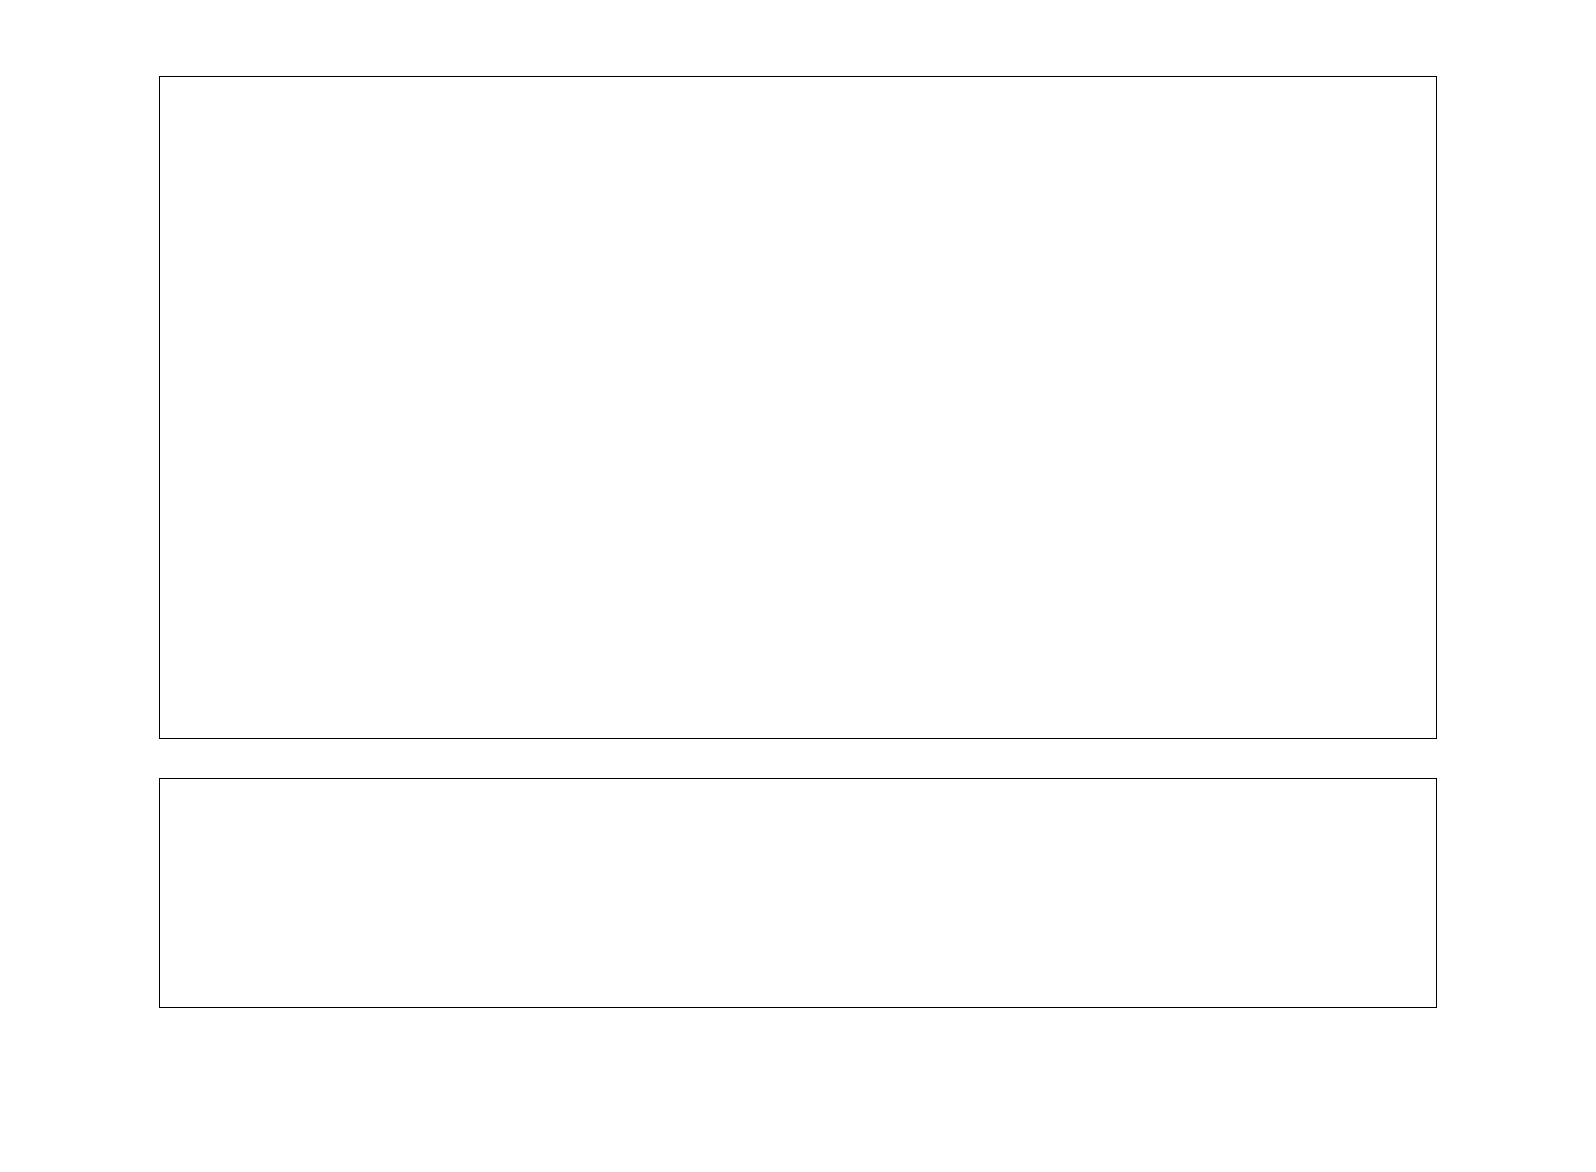

In [40]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
cut = 'fidVol'
name = '_00'
side_right = 'right'
side_left = 'left'
#NuCC_w.make_stacked_histo_weightV2(cut,'cos(TrackTheta)','EventWeight','Cos(theta)',-1,1,20,'cosTheta'+name,side_left)
#NuCC_w.make_stacked_histo_weightV2(cut,'nr_crthit_top','EventWeight','nr_crthit_top',-1,40,41,'CRTTophits'+name,side_left)
cut = 'fidVol'
name = '_precut'
side_right = 'right'
side_left = 'left'
#NuCC_w.make_stacked_histo_weightV2(cut,'nr_crthit_top','EventWeight','nr_crthit_top',-1,40,41,'CRTTophits'+name,side_left)
NuCC_w.make_stacked_histo_weightV2(cut,'(nr_crthit_top==0)','EventWeight','nr_crthit_top',-2,2,5,'CRTTophits_cut'+name,side_left)
